<a href="https://colab.research.google.com/github/joshsbloom/swabseq/blob/master/kb/notebooks/barcode_swapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/joshsbloom/swabseq.git

Cloning into 'swabseq'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 835 (delta 45), reused 108 (delta 31), pack-reused 697
Receiving objects: 100% (835/835), 29.05 MiB | 10.04 MiB/s, done.
Resolving deltas: 100% (373/373), done.


# Install packages

In [2]:
!pip install anndata

     |████████████████████████████████| 122kB 2.7MB/s 


In [3]:
# Convert samplesheet to csv for loading
def samplesheet_to_csv(samplesheet, csv):
    with open(samplesheet, 'r') as ss, open(csv,'w') as c:
        line = ss.readline().strip()
        while line != '[Data]':
            line = ss.readline().strip()

        # the rest of the lines are data
        for line in ss:
          c.write(line)
samplesheet_to_csv("/content/swabseq/kb/data/v19/samplesheet.csv", "ss.csv")

In [4]:
!head ss.csv

Plate_ID,virus_identity,lysate,virus_copy,bc_set,Plate_384,Plate_384_quadrant,MasterMixVol,RT,SpikeCopies,RPP_strategy,Sample_Well,Sample_ID,index,index2
Plate1,U0052,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A01,Plate1-A01-1,GTGAGTCTGT,GCACTCAATT
Plate1,U0052,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A01,Plate1-A01-2,TCACCGCAAC,CCATGGTGAA
Plate1,N4078,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A02,Plate1-A02-1,CAGCATTGCA,CTTCTAGCAT
Plate1,N4078,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A02,Plate1-A02-2,TATGACAGCC,ATGCGTACAA
Plate1,U0069,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A03,Plate1-A03-1,GTTACATCGG,CGTTATCTCA
Plate1,U0069,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A03,Plate1-A03-2,ATGTTCTCAG,AGGCGGAGAT
Plate1,N4086,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A04,Plate1-A04-1,AACGTGACGC,TCG

# Python analysis

In [5]:
#@title Imports
import anndata
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec


def nd(arr):
  return np.asarray(arr).reshape(-1)

def yex(ax, offset=0):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, np.array(lims)+offset, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

#  Load data

In [6]:
adata = anndata.read_h5ad("/content/swabseq/kb/data/v19/matrix.h5ad")
adata.obs['index'] = adata.obs.index.str.slice(0, 10)
adata.obs['index2'] = adata.obs.index.str.slice(10)

In [7]:
ss = pd.read_csv('ss.csv')
ss['bcs'] = ss['index'] + ss['index2']
ss.index = ss['bcs']
print(ss.bcs.nunique())
samples = ss['Sample_ID'].values
index = ss['index'].values
index2 = ss['index2'].values

576


# Collapse the Rpp30 and S and S spike

In [8]:
data = adata[adata.obs.index.isin(ss.bcs.values)]
data = data[data.obs.sort_values("Sample_ID").index]

In [9]:
bcs_lst = data.obs.bcs.values.astype(str)

In [10]:
mtx = []
data.obs.groupby(["Plate_ID", "Sample_Well"]).apply(lambda x: mtx.append(nd(data.X[np.squeeze([np.where(bcs_lst == i)[0] for i in x.index.values] ) ].sum(axis=0))))
mtx = np.squeeze(mtx).astype(int)

In [11]:
mtx

array([[87381,  1312,     0,     0, 19049],
       [    1,  6700,     0,     0, 11392],
       [88092,    81,     0,     0,  4000],
       ...,
       [   18, 89766,     0,     0,  8734],
       [    3, 34805,     0,     0,  1264],
       [   16, 65127,     0,     0,   106]])

In [12]:
data.X.todense().astype(int)

matrix([[87380,  1312,     0,     0,     5],
        [    1,     0,     0,     0, 19044],
        [    1,  6698,     0,     0,     1],
        ...,
        [    0,     0,     0,     0,  1261],
        [   16, 65127,     0,     0,    14],
        [    0,     0,     0,     0,    92]])

In [13]:
obs = data.obs[~data.obs.Sample_ID.str.contains("-2").values]
var = data.var
ndata = anndata.AnnData(X=mtx, obs=obs, var=var)

# Sample count distribution

In [14]:
ndata

AnnData object with n_obs × n_vars = 287 × 5
    obs: 'Plate_ID', 'virus_identity', 'lysate', 'virus_copy', 'bc_set', 'Plate_384', 'Plate_384_quadrant', 'MasterMixVol', 'RT', 'SpikeCopies', 'RPP_strategy', 'Sample_Well', 'Sample_ID', 'index', 'index2', 'bcs'

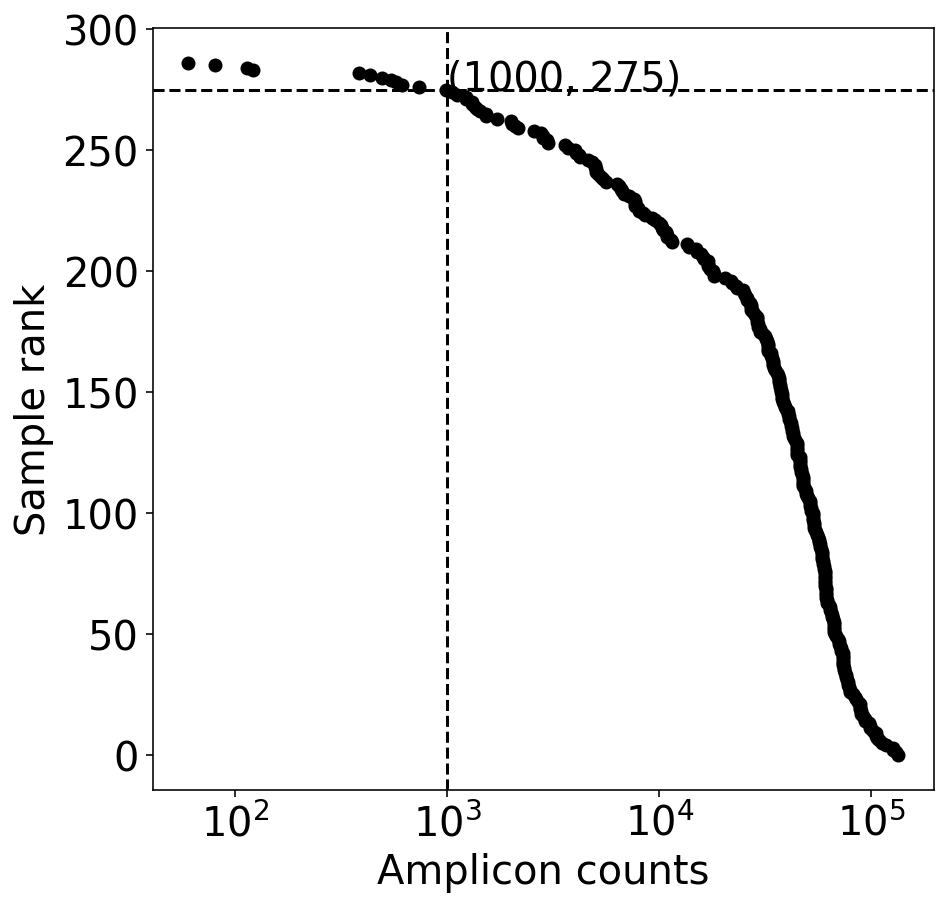

In [15]:
#@title Count distribution
fig, ax = plt.subplots(figsize=(7,7))

filter_counts = 1000
eps = 0.01

x = np.sort(nd(ndata.X[:,0:2].sum(axis=1)))[::-1] # only S and S spike
y = np.arange(len(x))
yidx = np.where(x<filter_counts)[0][0]
xx, yy = (filter_counts, y[yidx])

ax.axvline(x=xx, color="k", linestyle="--")
ax.axhline(y=yy, color="k", linestyle="--")

ax.scatter(x, y, color='k')


ax.annotate(f"({xx}, {yy})", (xx+eps, yy+eps))

ax.set(**{'xscale': 'symlog',
          'xlabel': 'Amplicon counts',
          'ylabel': 'Sample rank',
          })

plt.show()

# Enumerating all possibilities for barcode swapping

```
Let a barcode be either an index or index2 barcode then each barcode is associated with 

(Sample, Side, Amplicon) --> [S count, Spike count, Rpp30 count[]

Sample is an element from {1..N}
Side is an element from {1, 2} where 1 = left, 2 = right
Amplicon is an element from {1, 2} where 1 = S/spike amplicon, 2 = R amplicon
Note the amplicon is the amplicon associated with the barcode
```

In [16]:
# Are the two sides truly UDI
np.unique(np.array(ss['index'].values.tolist() + ss['index2'].values.tolist())).shape == ss.shape[0]*2

False

# The right way

In [17]:
ss['R_bcs'] = ss.Sample_ID.str.contains("-2")

In [18]:
mtx = adata.X.todense().astype(int)
index = adata.obs['index'].values
index2 = adata.obs['index2'].values

In [19]:
 # Remove the barcodes that are not UDI
all_bcs = ss['index'].values.tolist() +  ss['index2'].values.tolist()
bad = np.intersect1d(ss['index'].values, ss['index2'].values)
# bcs = np.setdiff1d(all_bcs, bad)
bad = np.unique(ss[np.logical_or(ss["index"].isin(bad), ss["index2"].isin(bad))]["index"].values.tolist() + ss[np.logical_or(ss["index"].isin(bad), ss["index2"].isin(bad))]["index2"].values.tolist())

In [20]:
bad

array(['AATCCGATGG', 'CACAGGATCG', 'CTCGCTTGAG', 'CTGAGTTACG',
       'GACTGACATG', 'GCTAGCCTCT'], dtype='<U10')

In [21]:
cleanss = ss[np.logical_or(~ss["index"].isin(bad), ~ss["index2"].isin(bad))]

In [22]:
cleanss.shape, ss.shape

((572, 17), (576, 17))

In [23]:
left = pd.DataFrame(np.vstack((cleanss[["index", "R_bcs"]].values, cleanss[["index2", "R_bcs"]].values)), columns=["bcs", "r_bcs"])
right = pd.DataFrame(np.vstack((cleanss[["index2", "R_bcs"]].values, cleanss[["index", "R_bcs"]].values)), columns=["bcs", "r_bcs"])

In [24]:
fwd_mask = [True]*len(cleanss)
rvs_mask = [False]*len(cleanss)
dir_mask = np.array(fwd_mask + rvs_mask)

isr_mask = cleanss.R_bcs.values.astype(bool)

In [25]:
cleanss.head()

,Plate_ID,virus_identity,lysate,virus_copy,bc_set,Plate_384,Plate_384_quadrant,MasterMixVol,RT,SpikeCopies,RPP_strategy,Sample_Well,Sample_ID,index,index2,bcs,R_bcs
bcs,,,,,,,,,,,,,,,,,
GTGAGTCTGTGCACTCAATT,Plate1,U0052,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A01,Plate1-A01-1,GTGAGTCTGT,GCACTCAATT,GTGAGTCTGTGCACTCAATT,False
TCACCGCAACCCATGGTGAA,Plate1,U0052,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A01,Plate1-A01-2,TCACCGCAAC,CCATGGTGAA,TCACCGCAACCCATGGTGAA,True
CAGCATTGCACTTCTAGCAT,Plate1,N4078,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A02,Plate1-A02-1,CAGCATTGCA,CTTCTAGCAT,CAGCATTGCACTTCTAGCAT,False
TATGACAGCCATGCGTACAA,Plate1,N4078,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A02,Plate1-A02-2,TATGACAGCC,ATGCGTACAA,TATGACAGCCATGCGTACAA,True
GTTACATCGGCGTTATCTCA,Plate1,U0069,NP swab into VTM,Negative Patient,N1_S2_RPP30,1,1,20uL,taqpath,500,50,A03,Plate1-A03-1,GTTACATCGG,CGTTATCTCA,GTTACATCGGCGTTATCTCA,False


In [26]:
conf = np.zeros((2, left.shape[0], right.shape[0])).astype(int)

n_obs = mtx.shape[0]

for idx, (i1, i2, row) in enumerate(zip(index, index2, mtx)):
  if idx%10000==0:
    print(f'{idx:,.0f} of {n_obs:,.0f}')
    
  s_cnt, s_spike_cnt, n_cnt, n_spike_cnt, rpp30_cnt = nd(row).astype(int)

  if i1 not in bad and i2 not in bad:
    lidx = np.where(left == i1)[0][0]
    ridx = np.where(right == i2)[0][0]


    conf[0, lidx, ridx] += s_cnt+s_spike_cnt
    conf[1, lidx, ridx] += rpp30_cnt

0 of 107,051
10,000 of 107,051
20,000 of 107,051
30,000 of 107,051
40,000 of 107,051
50,000 of 107,051
60,000 of 107,051
70,000 of 107,051
80,000 of 107,051
90,000 of 107,051
100,000 of 107,051


In [27]:
# flipped barcodes are zero (because we remove them in the correct step)
print(conf[0][~dir_mask,:][:,~dir_mask].sum())
print(conf[1][~dir_mask,:][:,~dir_mask].sum())

0
0


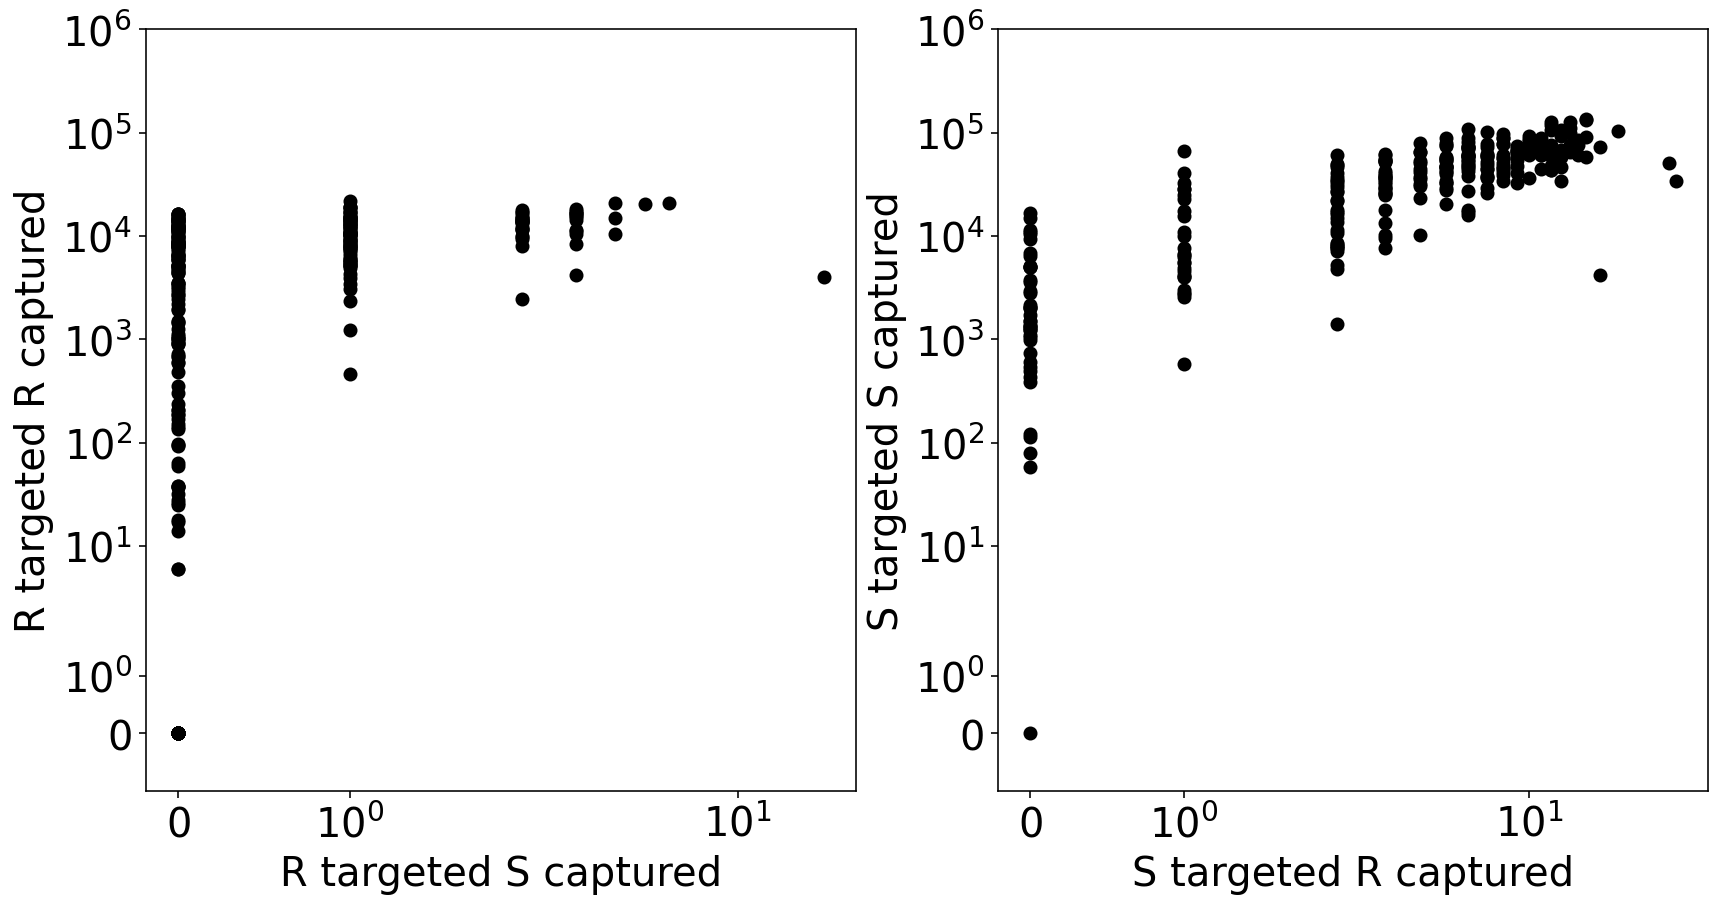

In [28]:
fig, ax = plt.subplots(figsize=(14,7), ncols=2)

x = np.diag(conf[0])[dir_mask][isr_mask]
y = np.diag(conf[1])[dir_mask][isr_mask]

ax[0].scatter(x, y, color="k")

kwd = {
    "yscale":"symlog",
    "xscale":"symlog",
    "xlabel": "R targeted S captured",
    "ylabel": "R targeted R captured",
    "ylim": (-1, 10**6)
}
ax[0].set(**kwd)
#############################
x = np.diag(conf[1])[dir_mask][~isr_mask]
y = np.diag(conf[0])[dir_mask][~isr_mask]

ax[1].scatter(x, y, color="k")

kwd = {
    "yscale":"symlog",
    "xscale":"symlog",
    "xlabel": "S targeted R captured",
    "ylabel": "S targeted S captured",
    "ylim": (-1, 10**6)
}
ax[1].set(**kwd)

fig.show()

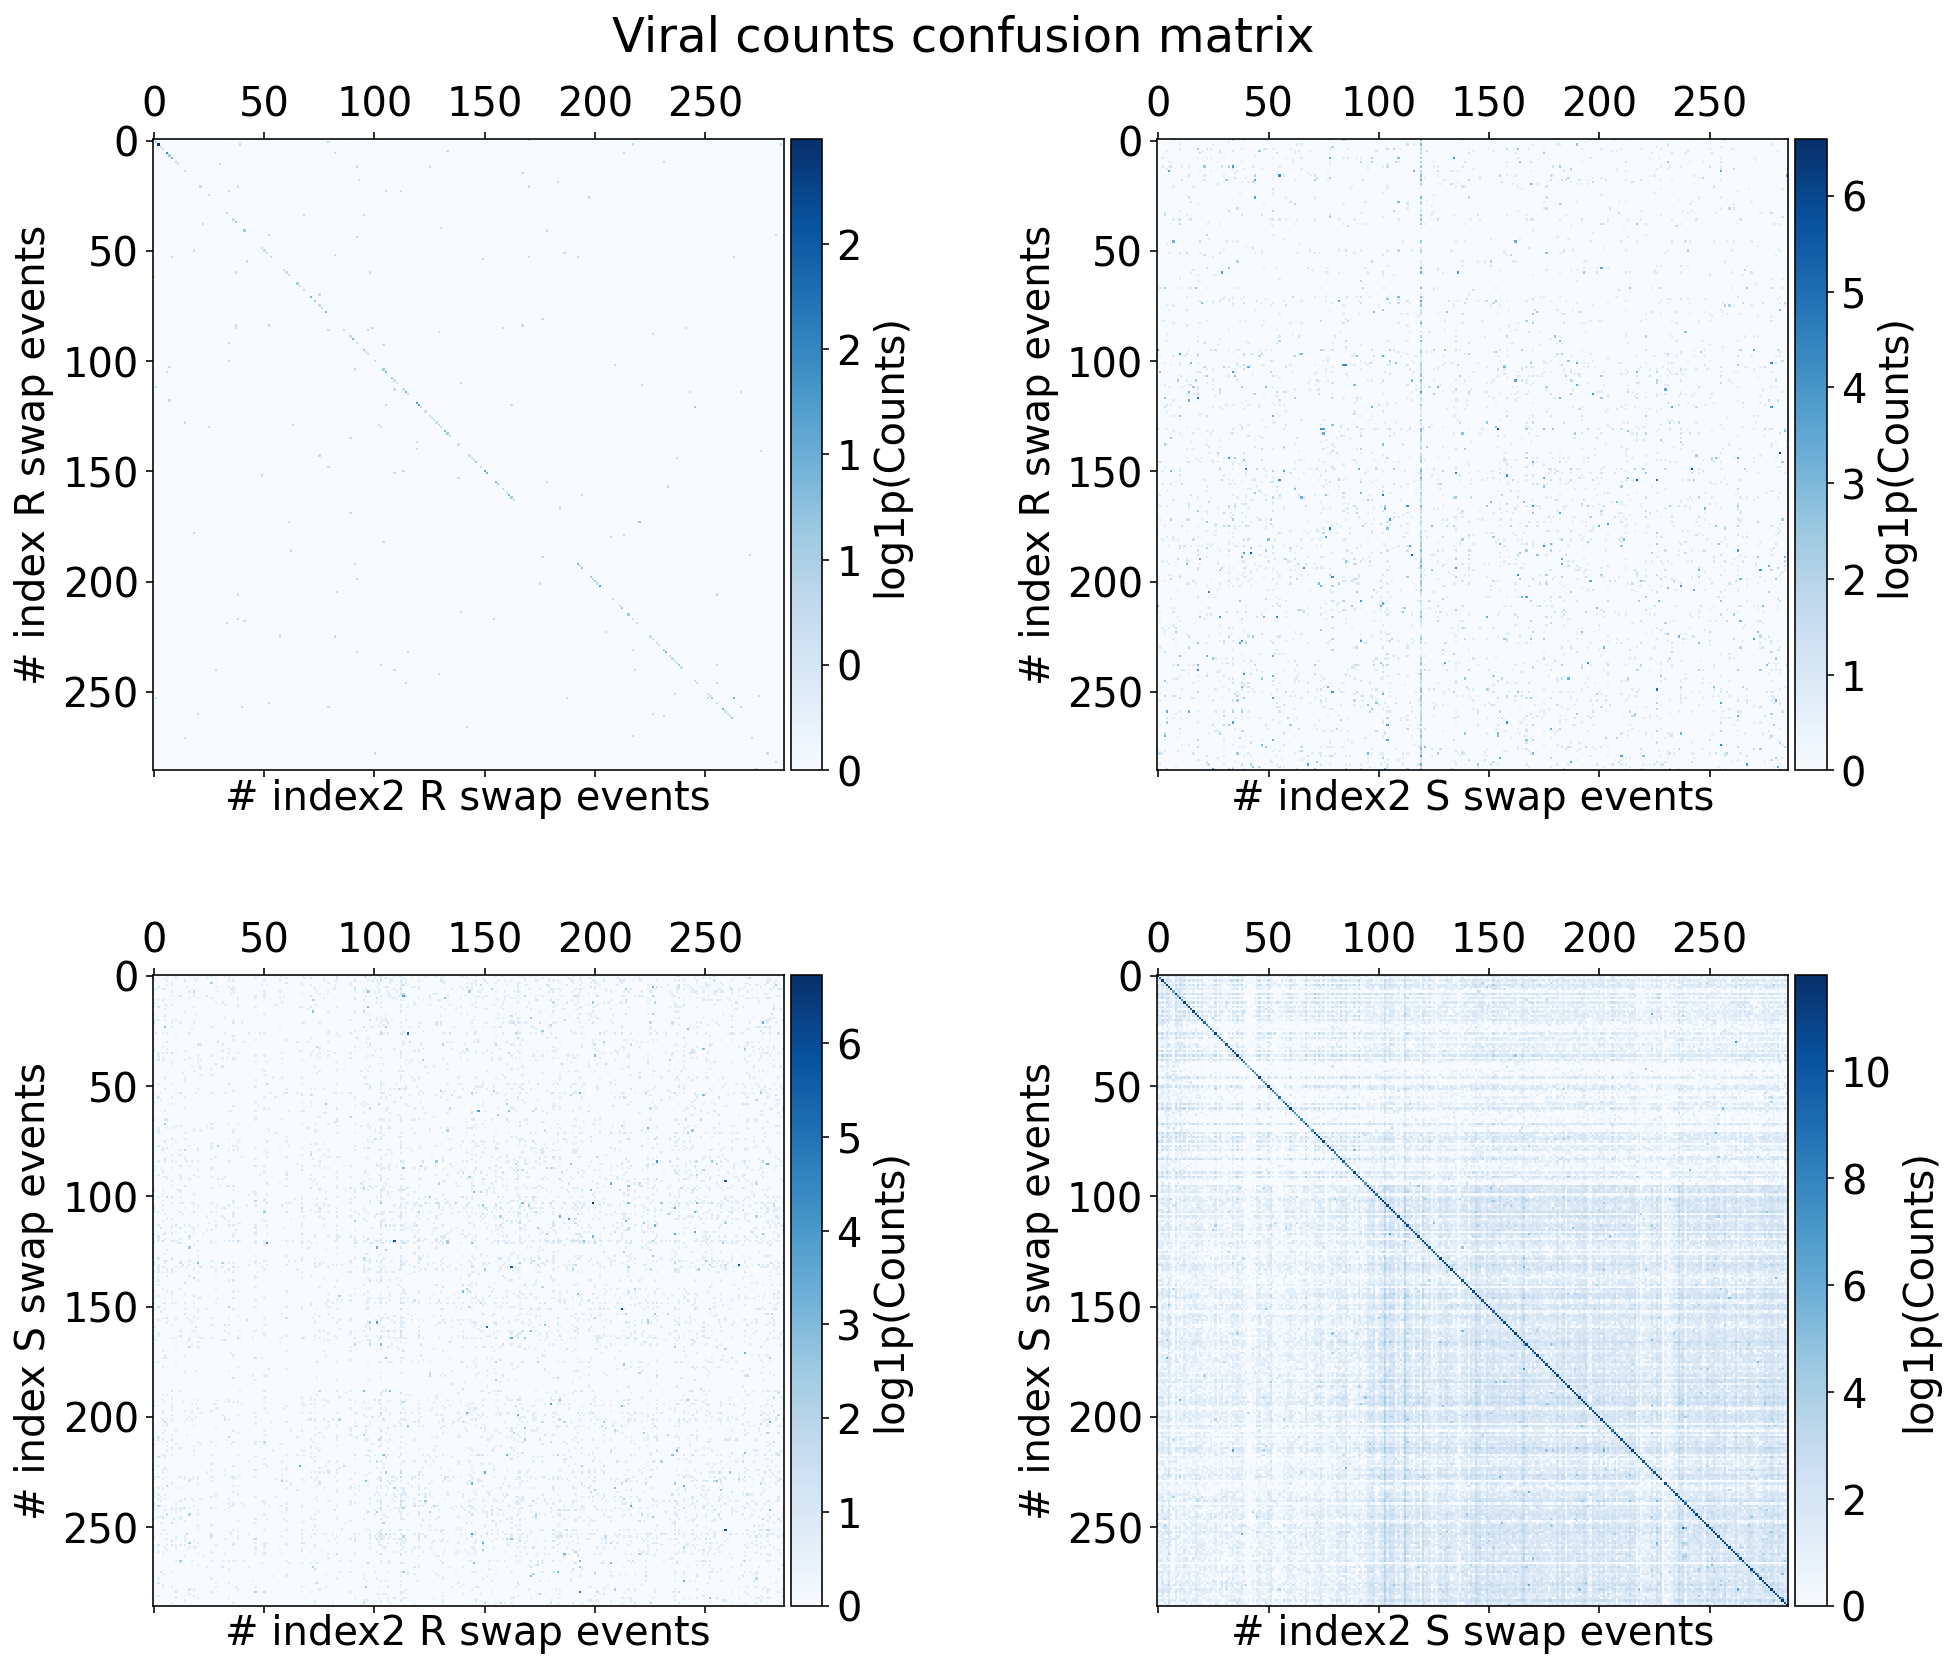

In [29]:
#@title Viral counts confusion matrix

def fmt(s, pos):
  x = int(s)
  return f"{x:,.0f}"
def cbar(sc, loc):
  divider = make_axes_locatable(loc)
  cax = divider.append_axes('right', size='5%', pad=0.05)

  fig.colorbar(sc, cax=cax, orientation='vertical', format=mpl.ticker.FuncFormatter(fmt), label="log1p(Counts)")
  return

mat = np.log1p(conf[0][dir_mask,:][:,dir_mask])

#######
fig, ax = plt.subplots(figsize=(15,15), ncols=2, nrows=2)
fig.subplots_adjust(hspace=0.05, wspace=0.5)

fig.suptitle("Viral counts confusion matrix", y=0.9)

kwd = {
    "xlabel": "# index2 R swap events",
    "ylabel": "# index R swap events"
}

###
loc = ax[0,0]

submat = mat[isr_mask,:][:,isr_mask]

im = loc.matshow(submat, cmap='Blues')

loc.set(**kwd)
cbar(im, loc)

##################
loc = ax[0, 1]

submat = mat[~isr_mask,:][:,isr_mask]

im = loc.matshow(submat, cmap='Blues')
kwd.update({
    "xlabel": "# index2 S swap events",
    "ylabel": "# index R swap events"
    })
loc.set(**kwd)
cbar(im, loc)


#################
loc = ax[1, 0]
submat = mat[isr_mask,:][:,~isr_mask]

im = loc.matshow(submat, cmap='Blues')
kwd.update({
    "xlabel": "# index2 R swap events",
    "ylabel": "# index S swap events"
    })
loc.set(**kwd)
cbar(im, loc)

###############
loc = ax[1, 1]

submat = mat[~isr_mask,:][:,~isr_mask]

im = loc.matshow(submat, cmap='Blues')

kwd.update({
    "xlabel": "# index2 S swap events",
    "ylabel": "# index S swap events"
    })
loc.set(**kwd)
cbar(im, loc)

fig.show()

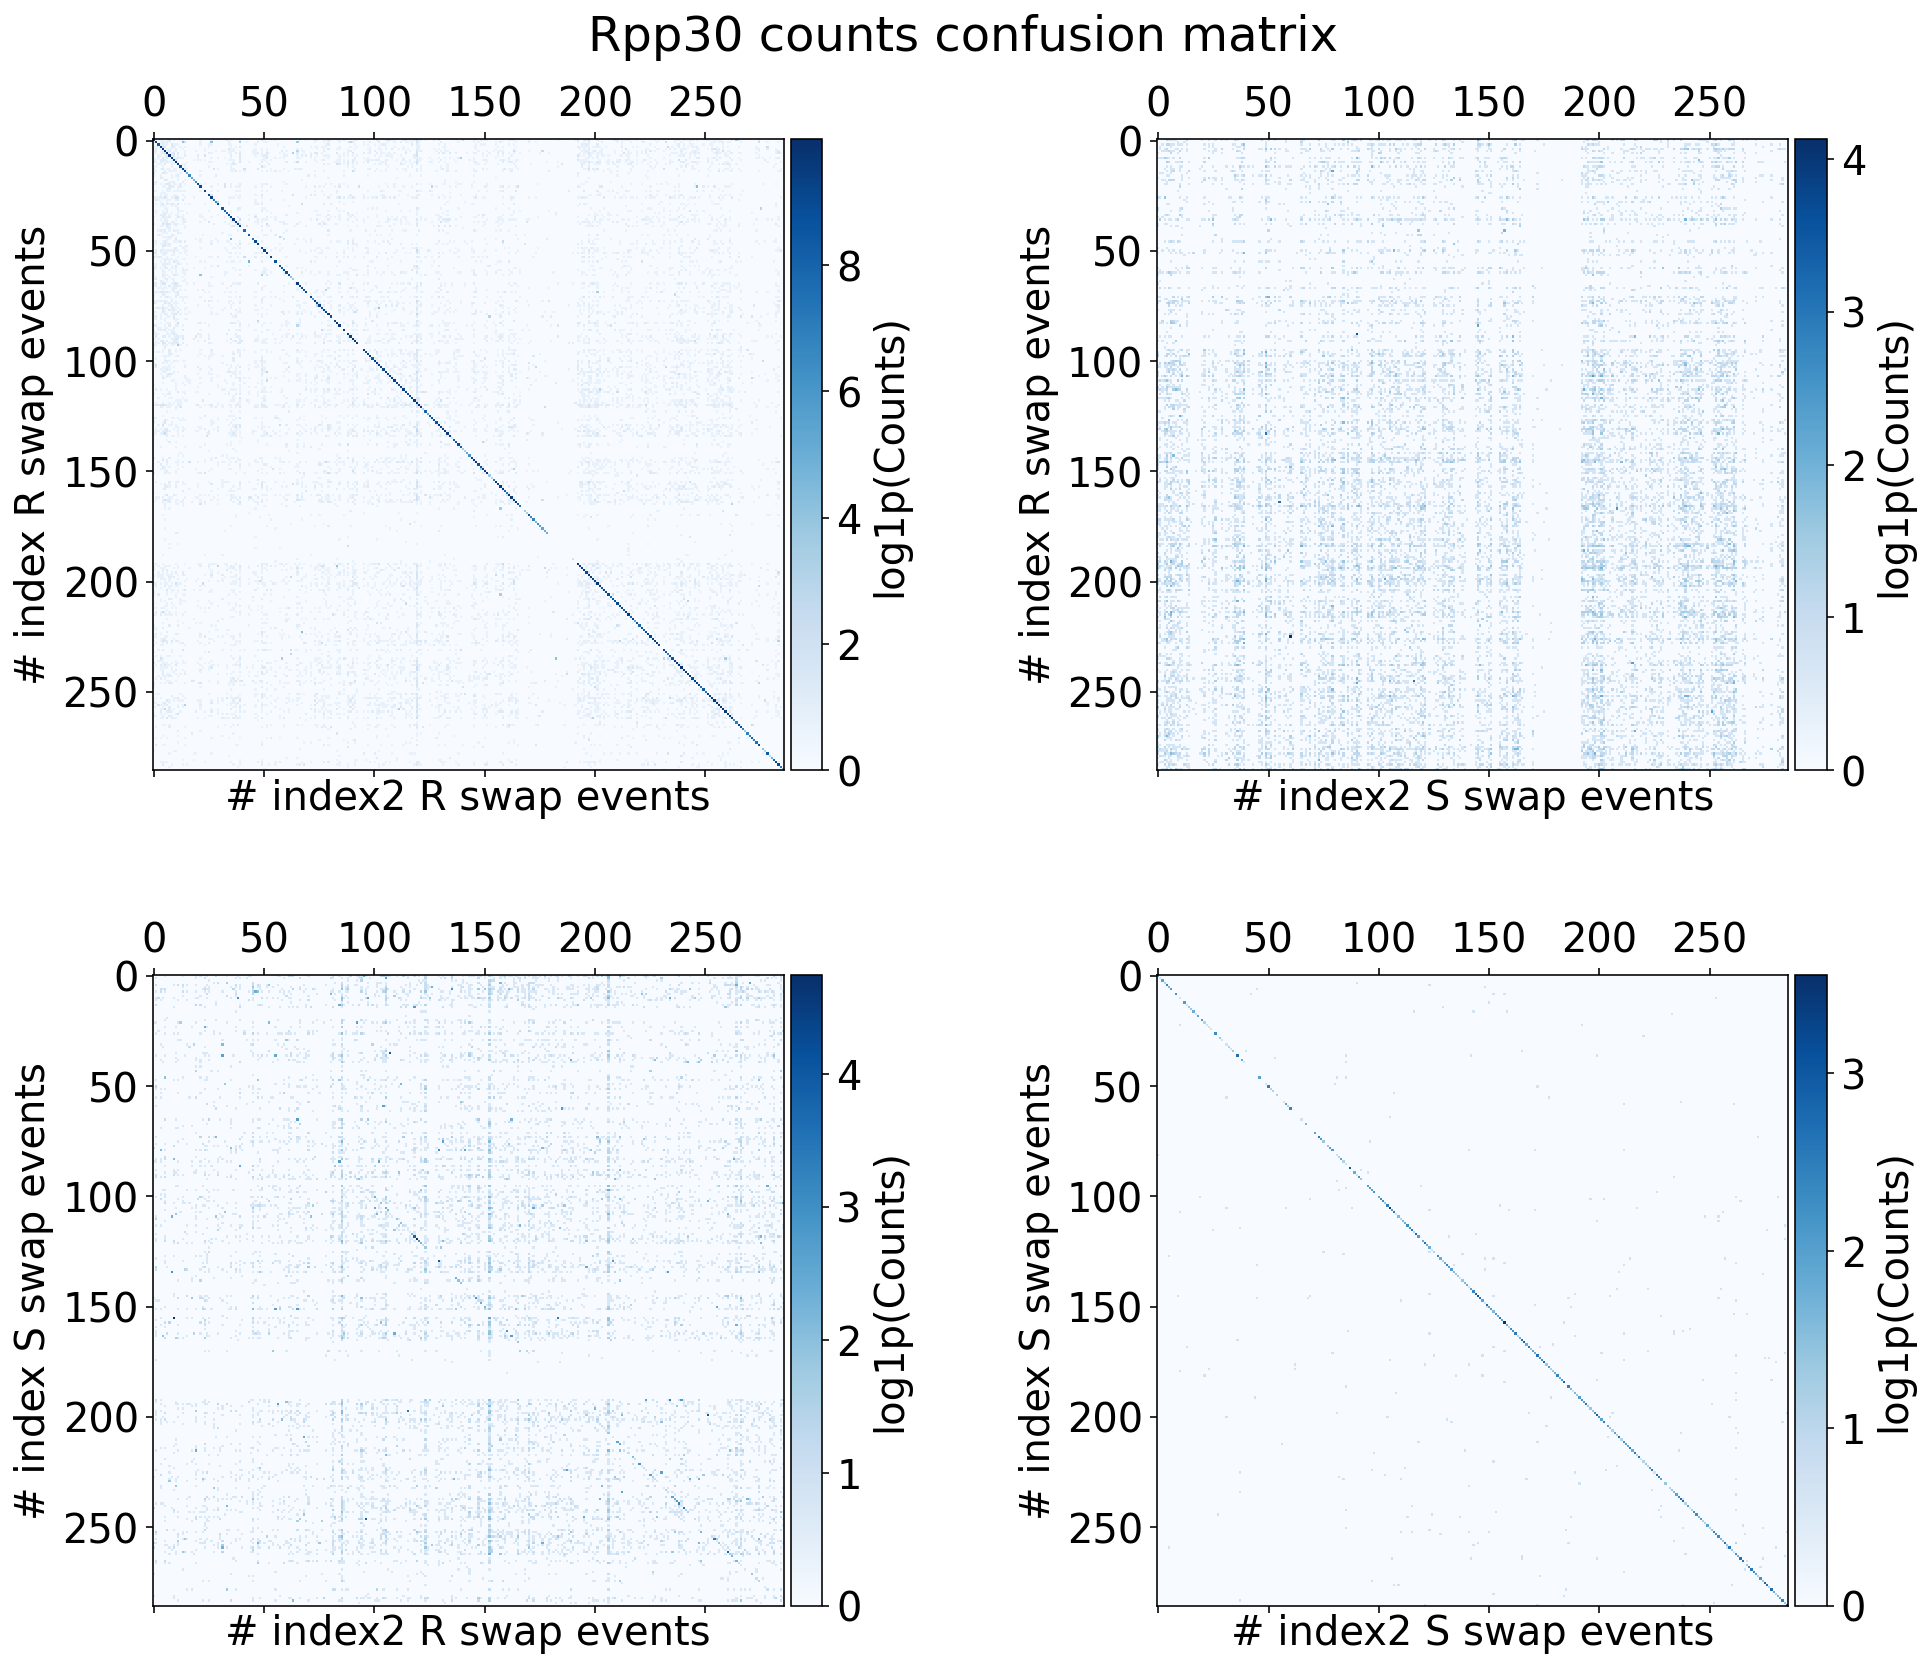

In [30]:
#@title Rpp30 counts confusion matrix

def fmt(s, pos):
  x = int(s)
  return f"{x:,.0f}"
def cbar(sc, loc):
  divider = make_axes_locatable(loc)
  cax = divider.append_axes('right', size='5%', pad=0.05)

  fig.colorbar(sc, cax=cax, orientation='vertical', format=mpl.ticker.FuncFormatter(fmt), label="log1p(Counts)")
  return

mat = np.log1p(conf[1][dir_mask,:][:,dir_mask])

#######
fig, ax = plt.subplots(figsize=(15,15), ncols=2, nrows=2)
fig.subplots_adjust(hspace=0.05, wspace=0.5)

fig.suptitle("Rpp30 counts confusion matrix", y=0.9)

kwd = {
    "xlabel": "# index2 R swap events",
    "ylabel": "# index R swap events"
}

###
loc = ax[0,0]

submat = mat[isr_mask,:][:,isr_mask]

im = loc.matshow(submat, cmap='Blues')

loc.set(**kwd)
cbar(im, loc)

##################
loc = ax[0, 1]

submat = mat[~isr_mask,:][:,isr_mask]

im = loc.matshow(submat, cmap='Blues')
kwd.update({
    "xlabel": "# index2 S swap events",
    "ylabel": "# index R swap events"
    })
loc.set(**kwd)
cbar(im, loc)


#################
loc = ax[1, 0]
submat = mat[isr_mask,:][:,~isr_mask]

im = loc.matshow(submat, cmap='Blues')
kwd.update({
    "xlabel": "# index2 R swap events",
    "ylabel": "# index S swap events"
    })
loc.set(**kwd)
cbar(im, loc)

###############
loc = ax[1, 1]

submat = mat[~isr_mask,:][:,~isr_mask]

im = loc.matshow(submat, cmap='Blues')

kwd.update({
    "xlabel": "# index2 S swap events",
    "ylabel": "# index S swap events"
    })
loc.set(**kwd)
cbar(im, loc)

fig.show()

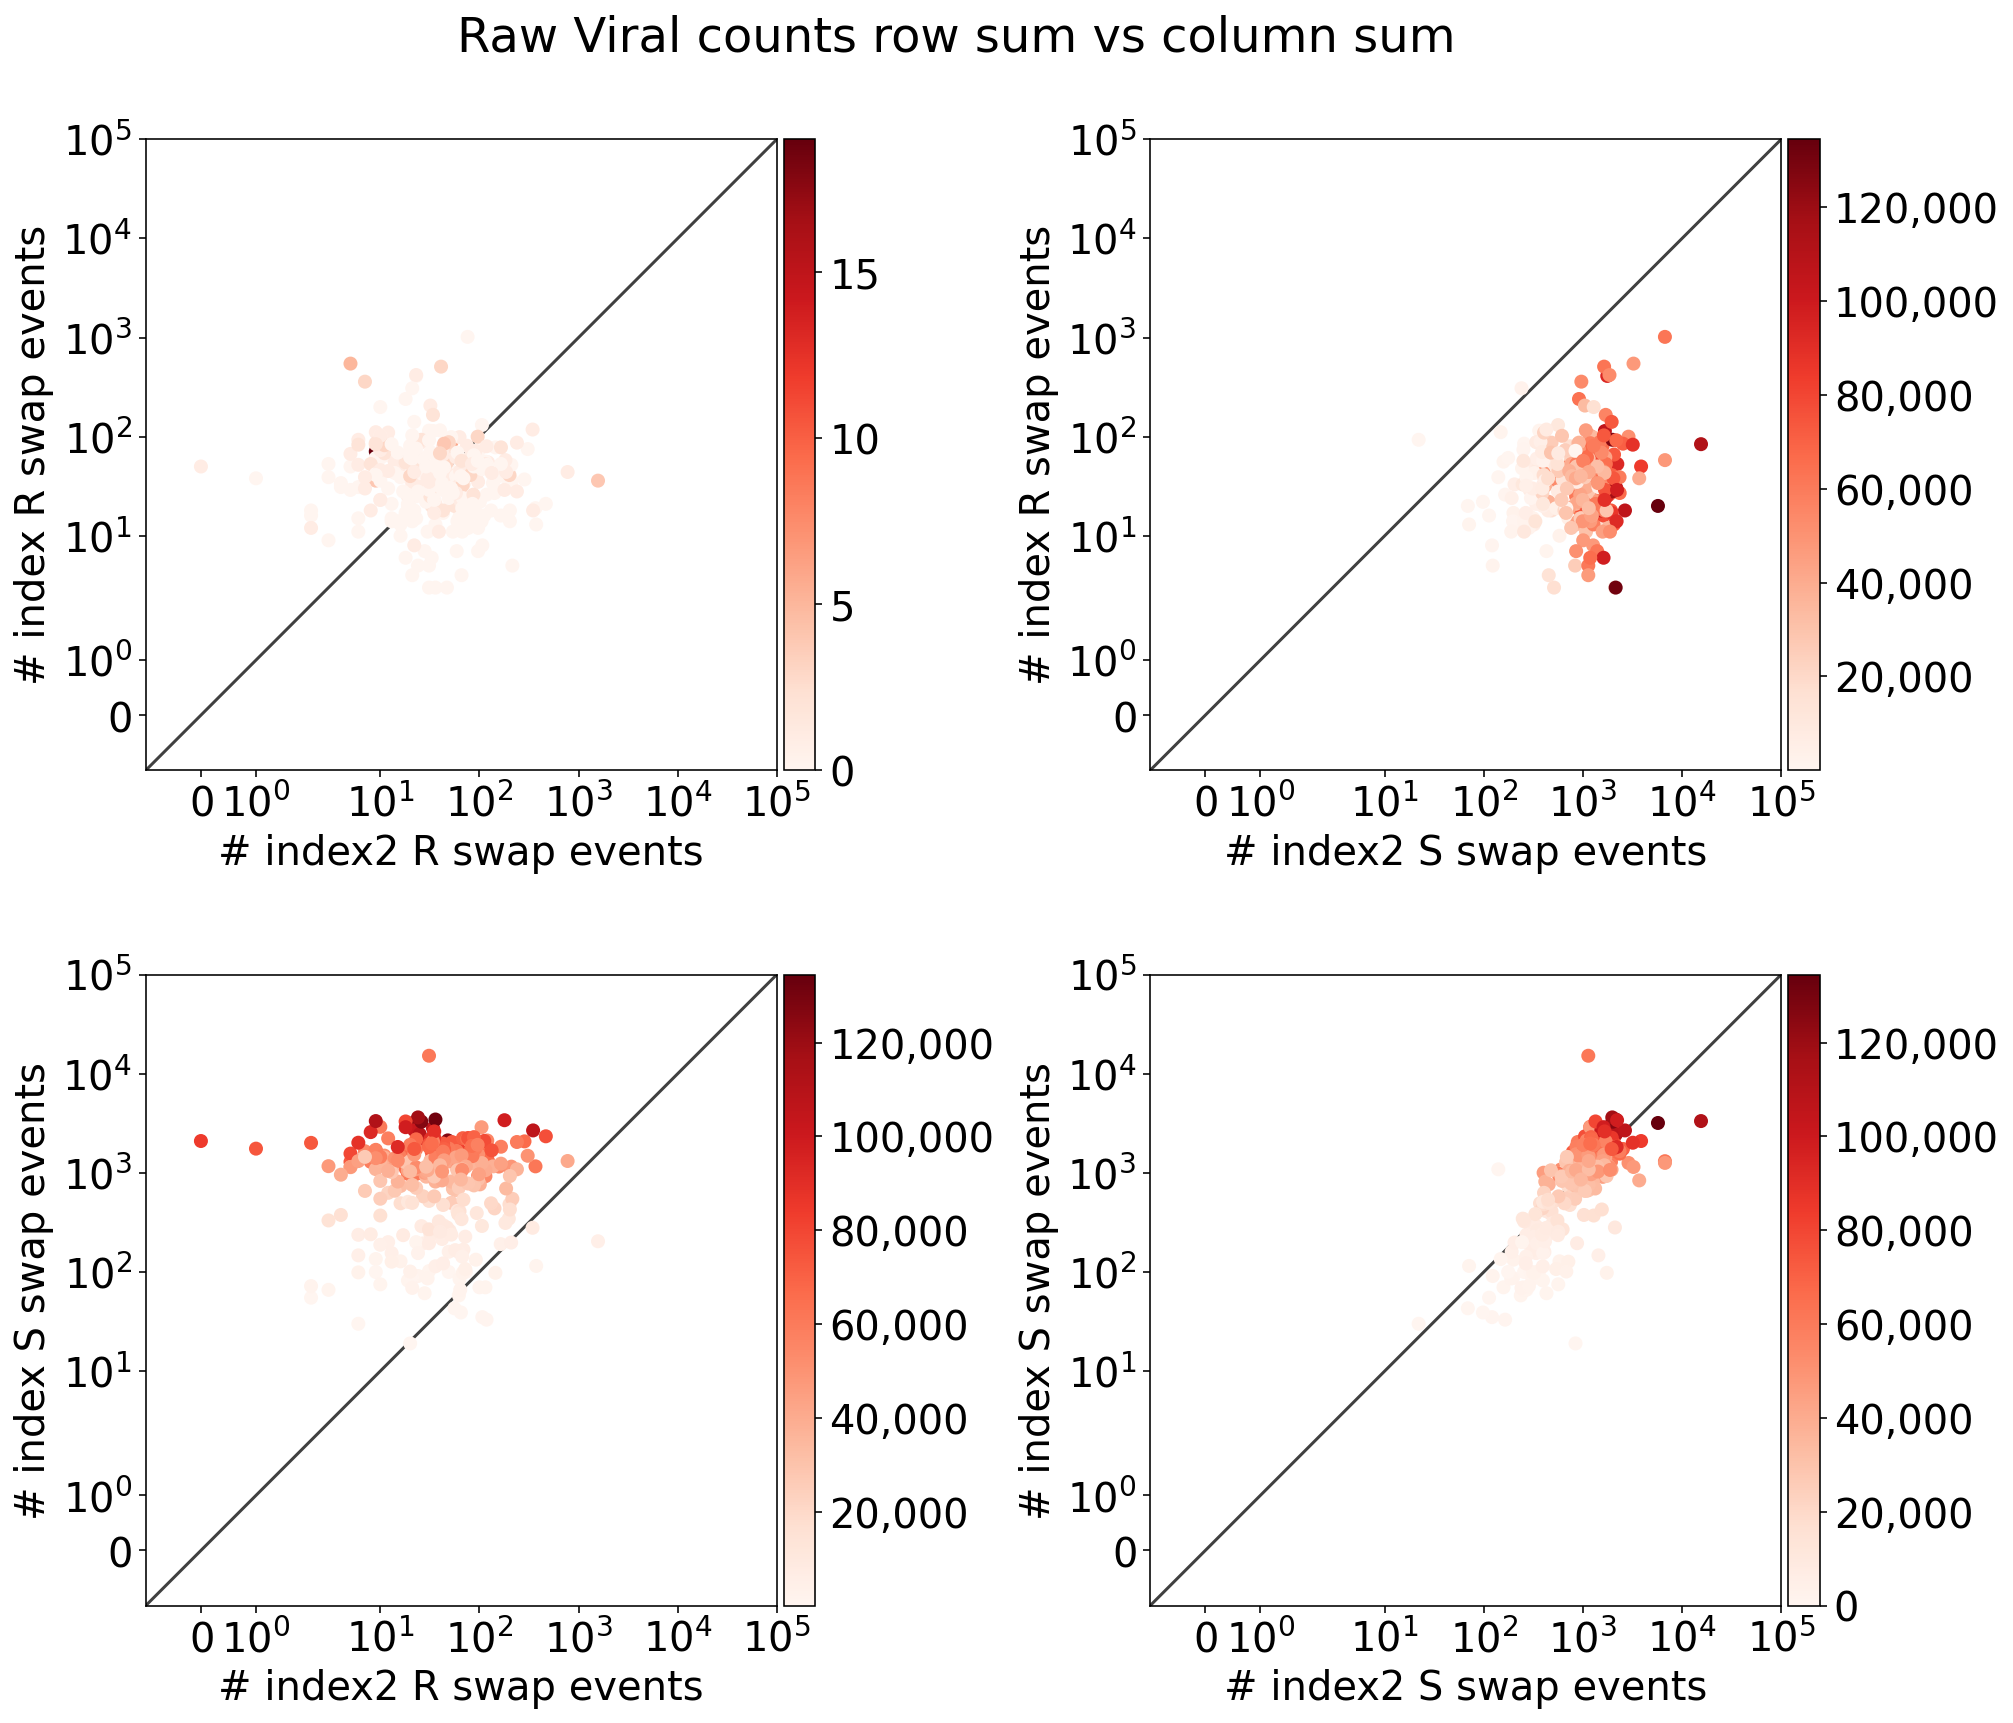

In [31]:
#@title Raw Viral Counts

def fmt(s, pos):
  x = int(s)
  return f"{x:,.0f}"
def cbar(sc, loc):
  divider = make_axes_locatable(loc)
  cax = divider.append_axes('right', size='5%', pad=0.05)

  fig.colorbar(sc, cax=cax, orientation='vertical', format=mpl.ticker.FuncFormatter(fmt))
  return

diag = np.diag(conf[0])[dir_mask]

off_0 = conf[0].sum(axis=0)[dir_mask] - diag
off_1 = conf[0].sum(axis=1)[dir_mask] - diag


#######
fig, ax = plt.subplots(figsize=(15,15), ncols=2, nrows=2)
fig.subplots_adjust(hspace=0.05, wspace=0.5)

fig.suptitle("Raw Viral counts row sum vs column sum", y=0.9)

kwd = {
    "xscale": "symlog",
    "yscale": "symlog",
    "xlim": (-1, 1e5),
    "ylim": (-1, 1e5),
    "xlabel": "# index2 R swap events",
    "ylabel": "# index R swap events"
}

###
loc = ax[0,0]
well_total = diag[isr_mask]

x = off_0[isr_mask] # _0 is index2
y = off_1[isr_mask] # _1 is index

sc = loc.scatter(x, y, c=well_total, cmap="Reds")

loc.set(**kwd)
yex(loc)
cbar(sc, loc)

##################
loc = ax[0, 1]

well_total = diag[~isr_mask] + diag[isr_mask]

x = off_0[~isr_mask]
y = off_1[isr_mask]

sc = loc.scatter(x, y, c=well_total, cmap="Reds")

kwd.update({
    "xlabel": "# index2 S swap events",
    "ylabel": "# index R swap events"
    })

loc.set(**kwd)

yex(loc)
cbar(sc, loc)

#################
loc = ax[1, 0]

well_total = diag[isr_mask] + diag[~isr_mask]
x = off_0[isr_mask]
y = off_1[~isr_mask]

sc = loc.scatter(x, y, c=well_total, cmap="Reds")
kwd.update({
    "xlabel": "# index2 R swap events",
    "ylabel": "# index S swap events"
    })
loc.set(**kwd)

yex(loc)
cbar(sc, loc)

###############
loc = ax[1, 1]

well_total = diag[~isr_mask]

x = off_0[~isr_mask]
y = off_1[~isr_mask]

sc = loc.scatter(x, y, c=well_total, cmap="Reds")

kwd.update({
    "xlabel": "# index2 S swap events",
    "ylabel": "# index S swap events"
    })
loc.set(**kwd)

yex(loc)
cbar(sc, loc)

fig.show()

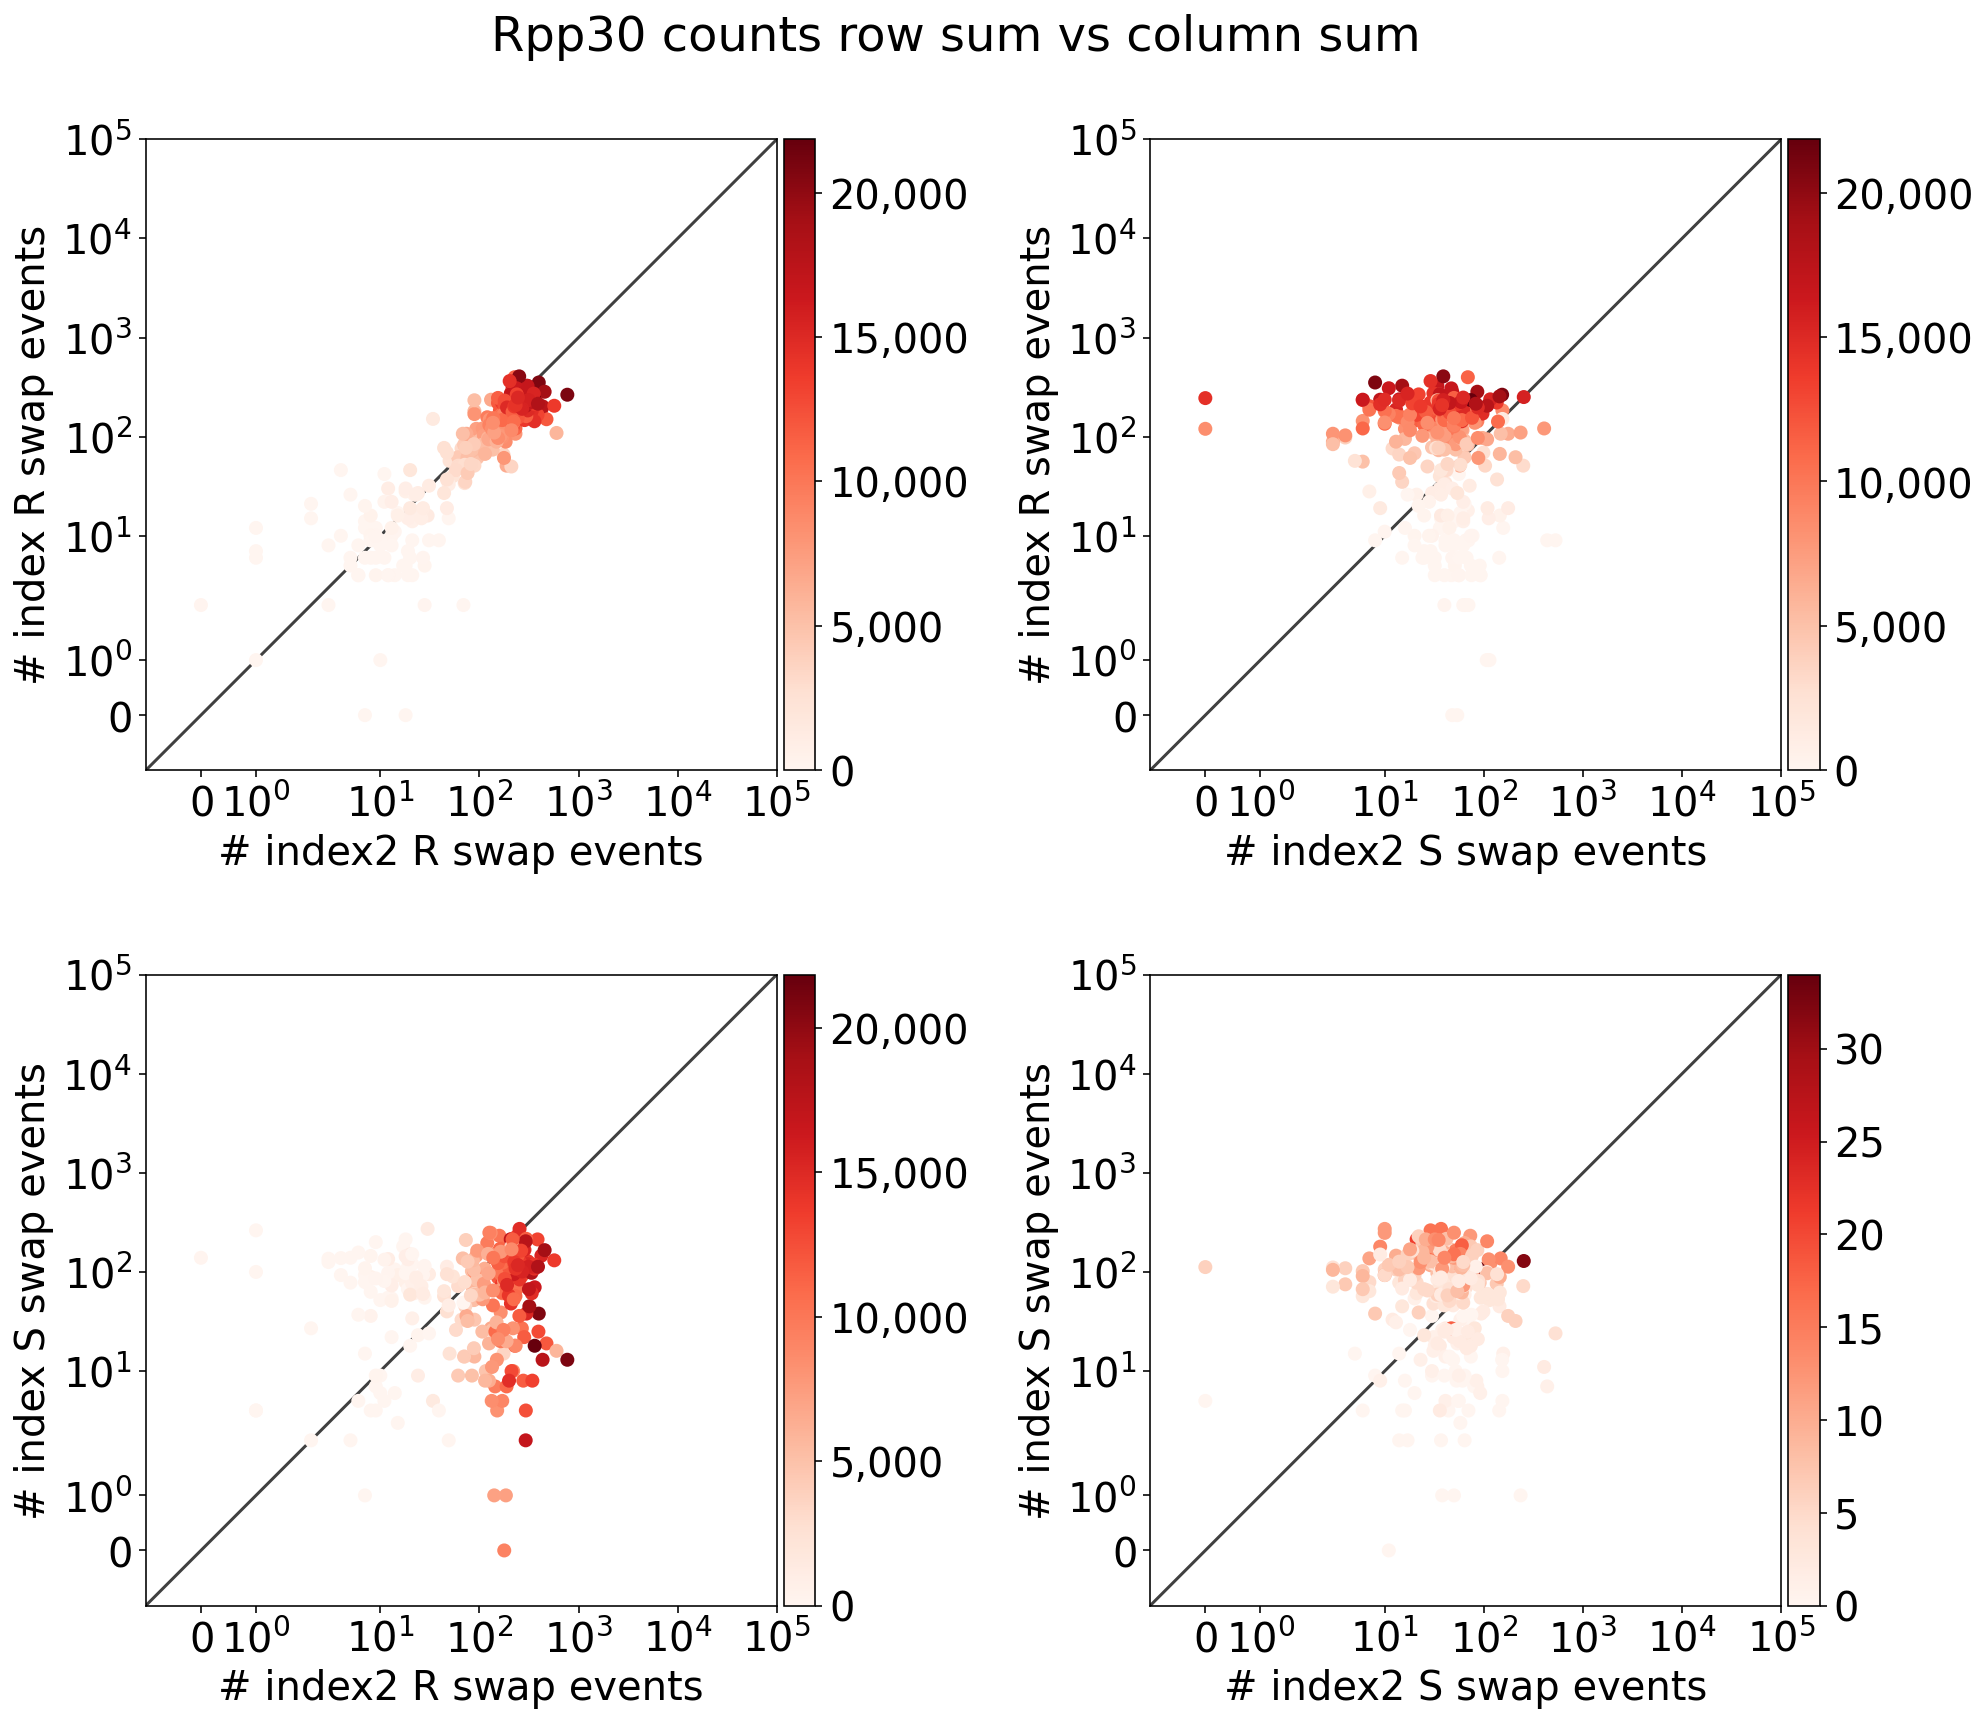

In [32]:
#@title Raw Rpp30 Counts

def fmt(s, pos):
  x = int(s)
  return f"{x:,.0f}"
def cbar(sc, loc):
  divider = make_axes_locatable(loc)
  cax = divider.append_axes('right', size='5%', pad=0.05)

  fig.colorbar(sc, cax=cax, orientation='vertical', format=mpl.ticker.FuncFormatter(fmt))
  return

diag = np.diag(conf[1])[dir_mask]

off_0 = conf[1].sum(axis=0)[dir_mask] - diag
off_1 = conf[1].sum(axis=1)[dir_mask] - diag


#######
fig, ax = plt.subplots(figsize=(15,15), ncols=2, nrows=2)
fig.subplots_adjust(hspace=0.05, wspace=0.5)

fig.suptitle("Rpp30 counts row sum vs column sum", y=0.9)

kwd = {
    "xscale": "symlog",
    "yscale": "symlog",
    "xlim": (-1, 1e5),
    "ylim": (-1, 1e5),
    "xlabel": "# index2 R swap events",
    "ylabel": "# index R swap events"
}

###
loc = ax[0,0]
well_total = diag[isr_mask]

x = off_0[isr_mask] # _0 is index2
y = off_1[isr_mask] # _1 is index

sc = loc.scatter(x, y, c=well_total, cmap="Reds")

loc.set(**kwd)
yex(loc)
cbar(sc, loc)

##################
loc = ax[0, 1]

well_total = diag[~isr_mask] + diag[isr_mask]

x = off_0[~isr_mask]
y = off_1[isr_mask]

sc = loc.scatter(x, y, c=well_total, cmap="Reds")

kwd.update({
    "xlabel": "# index2 S swap events",
    "ylabel": "# index R swap events"
    })

loc.set(**kwd)

yex(loc)
cbar(sc, loc)

#################
loc = ax[1, 0]

well_total = diag[isr_mask] + diag[~isr_mask]
x = off_0[isr_mask]
y = off_1[~isr_mask]

sc = loc.scatter(x, y, c=well_total, cmap="Reds")
kwd.update({
    "xlabel": "# index2 R swap events",
    "ylabel": "# index S swap events"
    })
loc.set(**kwd)

yex(loc)
cbar(sc, loc)

###############
loc = ax[1, 1]

well_total = diag[~isr_mask]

x = off_0[~isr_mask]
y = off_1[~isr_mask]

sc = loc.scatter(x, y, c=well_total, cmap="Reds")

kwd.update({
    "xlabel": "# index2 S swap events",
    "ylabel": "# index S swap events"
    })
loc.set(**kwd)

yex(loc)
cbar(sc, loc)

fig.show()

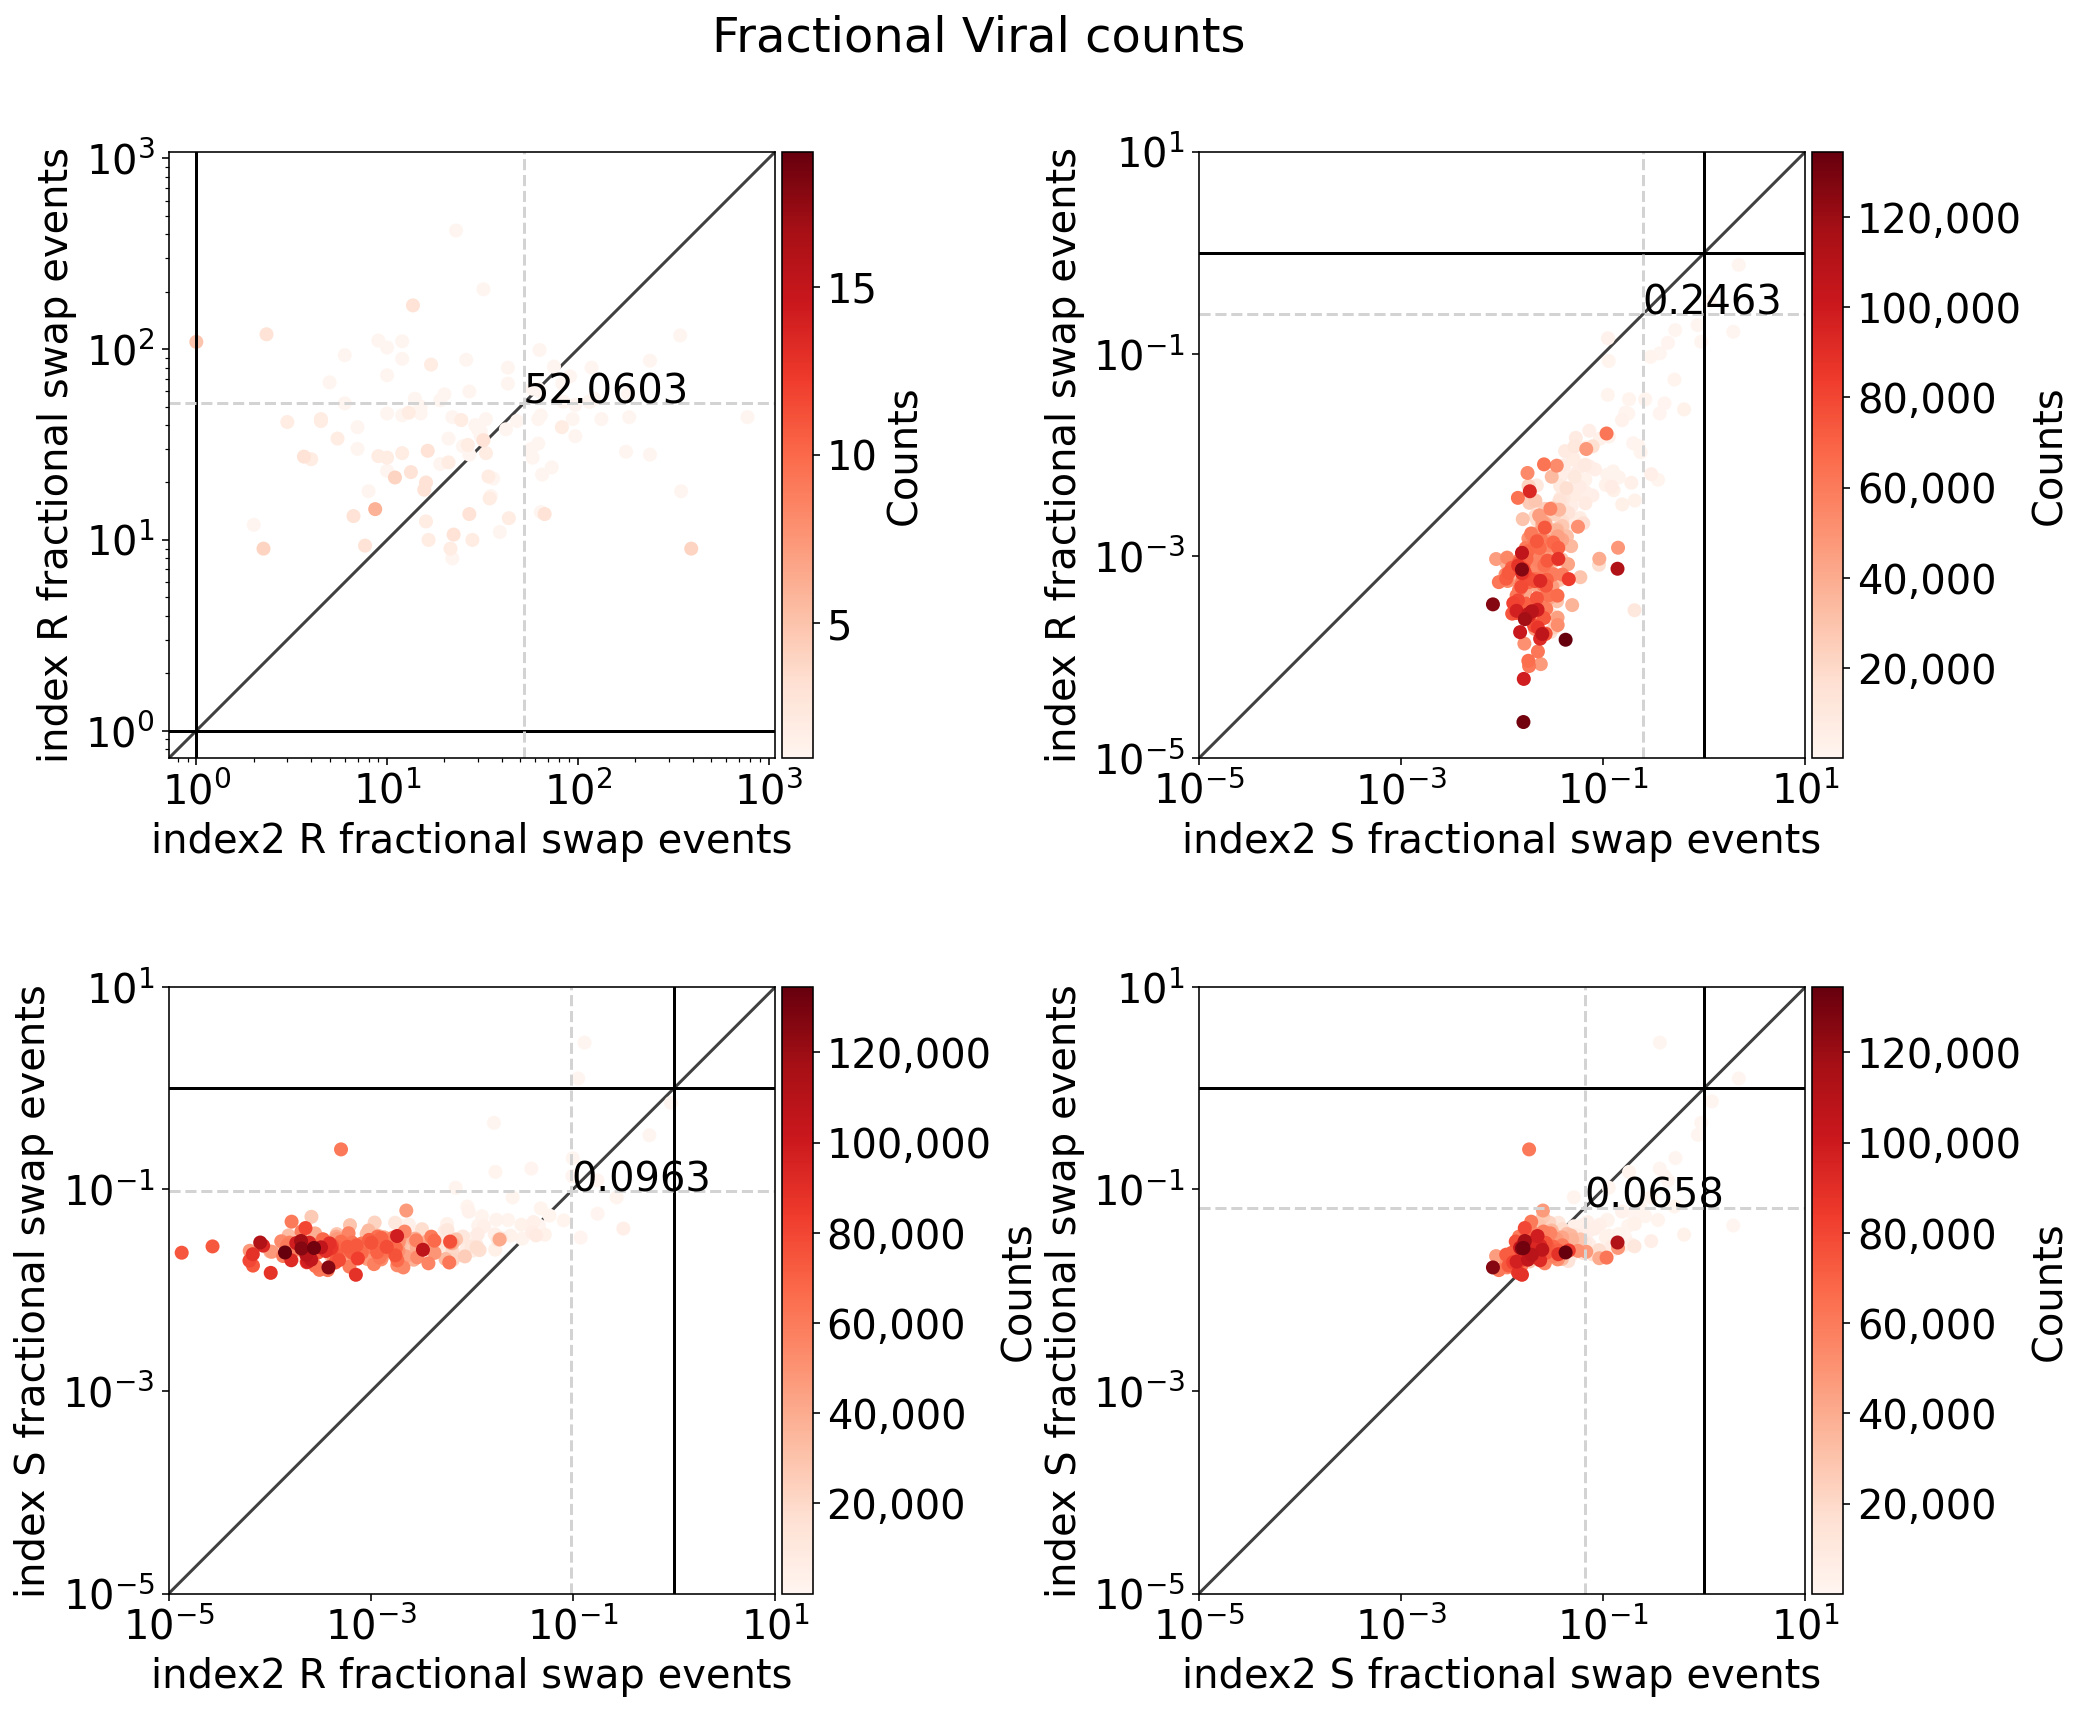

In [33]:
#@title Fractional Viral Counts

def fmt(s, pos):
  x = int(s)
  return f"{x:,.0f}"
def cbar(sc, loc):
  divider = make_axes_locatable(loc)
  cax = divider.append_axes('right', size='5%', pad=0.05)

  fig.colorbar(sc, cax=cax, orientation='vertical', format=mpl.ticker.FuncFormatter(fmt), label="Counts")
  return

def frac_scatter(x, y, c, ax=None):
  argsort = np.argsort(c)

  x = x[argsort]
  y = y[argsort]
  c = c[argsort]


  loc.axvline(x=1, color="black")
  loc.axhline(y=1, color="black")

  mean = np.mean([x, y], axis=1).mean()
  loc.axvline(x=mean, linestyle="--", color="lightgrey")
  loc.axhline(y=mean, linestyle="--", color="lightgrey")
  loc.annotate(f"{mean:,.4f}", (mean, mean))

  sc = loc.scatter(x, y, c=c, cmap="Reds")
  return sc

diag = np.diag(conf[0])[dir_mask]

off_0 = conf[0].sum(axis=0)[dir_mask] - diag
off_1 = conf[0].sum(axis=1)[dir_mask] - diag


#######
fig, ax = plt.subplots(figsize=(15,15), ncols=2, nrows=2)
fig.subplots_adjust(hspace=0.05, wspace=0.6)

fig.suptitle("Fractional Viral counts", y=0.9)

kwd = {
    "xscale": "log",
    "yscale": "log",
    "xlabel": "index2 R fractional swap events",
    "ylabel": "index R fractional swap events",

}

###
loc = ax[0,0]
well_total = diag[isr_mask]

m = well_total > 0
c = well_total[m]

x = off_0[isr_mask][m]/c # _0 is index2
y = off_1[isr_mask][m]/c # _1 is index

sc = frac_scatter(x, y, c, ax=loc)

loc.set(**kwd)
yex(loc)
cbar(sc, loc)

##################
loc = ax[0, 1]

well_total = diag[~isr_mask] + diag[isr_mask]
m = well_total > 00
c = well_total[m]

x = off_0[~isr_mask][m]/c # _0 is index2
y =  off_1[isr_mask][m]/c # _1 is index

sc = frac_scatter(x, y, c, ax=loc)

kwd.update({
    "xlabel": "index2 S fractional swap events",
    "ylabel": "index R fractional swap events",
    "xlim": (1e-5, 1e1),
    "ylim": (1e-5, 1e1),
    })

loc.set(**kwd)

yex(loc)
cbar(sc, loc)

#################
loc = ax[1, 0]

well_total = diag[isr_mask] + diag[~isr_mask]
m = well_total > 00
c = well_total[m]

x =  off_0[isr_mask][m]/c # _0 is index2
y = off_1[~isr_mask][m]/c # _1 is index

sc = frac_scatter(x, y, c, ax=loc)

kwd.update({
    "xlabel": "index2 R fractional swap events",
    "ylabel": "index S fractional swap events"
    })
loc.set(**kwd)

yex(loc)
cbar(sc, loc)

###############
loc = ax[1, 1]

well_total = diag[~isr_mask]
m = well_total > 00
c = well_total[m]

x = off_0[~isr_mask][m]/c # _0 is index2
y = off_1[~isr_mask][m]/c # _1 is index

sc = frac_scatter(x, y, c, ax=loc)

kwd.update({
    "xlabel": "index2 S fractional swap events",
    "ylabel": "index S fractional swap events"
    })
loc.set(**kwd)

yex(loc)
cbar(sc, loc)

fig.show()

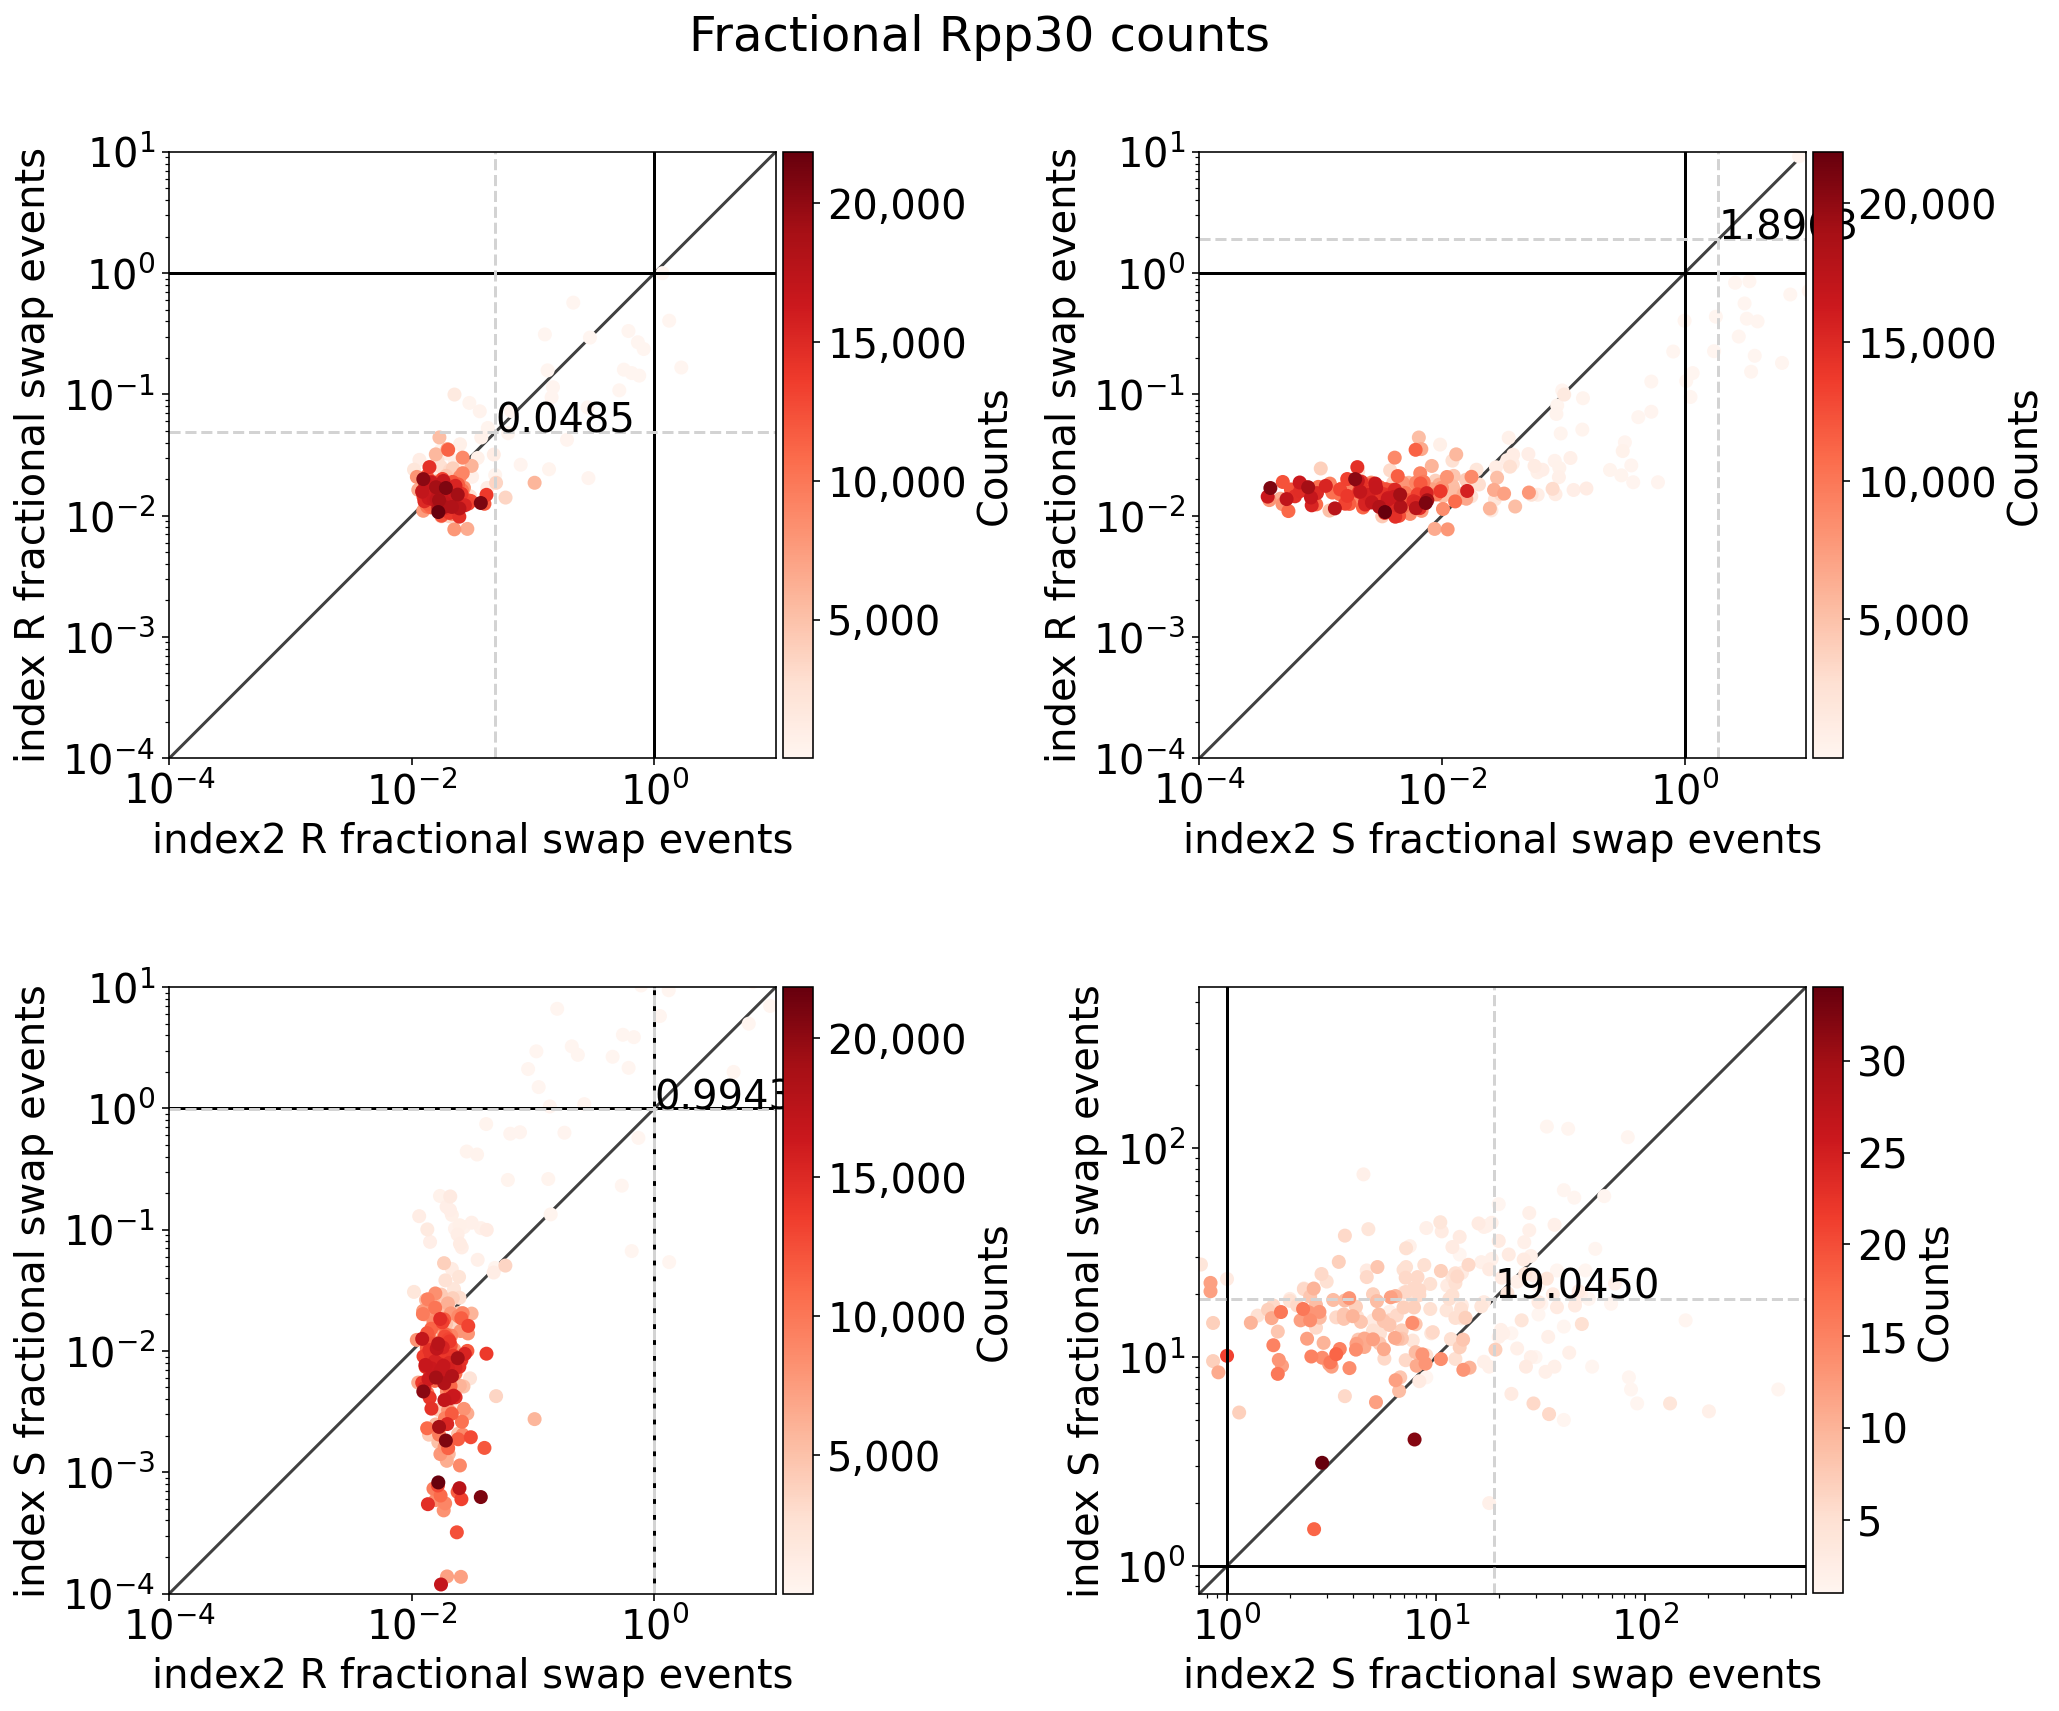

In [34]:
#@title Fractional Rpp30 Counts

def fmt(s, pos):
  x = int(s)
  return f"{x:,.0f}"
def cbar(sc, loc):
  divider = make_axes_locatable(loc)
  cax = divider.append_axes('right', size='5%', pad=0.05)

  fig.colorbar(sc, cax=cax, orientation='vertical', format=mpl.ticker.FuncFormatter(fmt), label="Counts")
  return

def frac_scatter(x, y, c, ax=None):
  argsort = np.argsort(c)

  x = x[argsort]
  y = y[argsort]
  c = c[argsort]


  loc.axvline(x=1, color="black")
  loc.axhline(y=1, color="black")

  mean = np.mean([x, y], axis=1).mean()
  loc.axvline(x=mean, linestyle="--", color="lightgrey")
  loc.axhline(y=mean, linestyle="--", color="lightgrey")
  loc.annotate(f"{mean:,.4f}", (mean, mean))

  sc = loc.scatter(x, y, c=c, cmap="Reds")
  return sc

diag = np.diag(conf[1])[dir_mask]

off_0 = conf[1].sum(axis=0)[dir_mask] - diag
off_1 = conf[1].sum(axis=1)[dir_mask] - diag


#######
fig, ax = plt.subplots(figsize=(15,15), ncols=2, nrows=2)
fig.subplots_adjust(hspace=0.05, wspace=0.6)

fig.suptitle("Fractional Rpp30 counts", y=0.9)

kwd = {
    "xscale": "log",
    "yscale": "log",
    "xlabel": "index2 R fractional swap events",
    "ylabel": "index R fractional swap events",
    "xlim": (1e-4, 1e1),
    "ylim": (1e-4, 1e1),

}

###
loc = ax[0,0]
well_total = diag[isr_mask]

m = well_total > 0
c = well_total[m]

x = off_0[isr_mask][m]/c # _0 is index2
y = off_1[isr_mask][m]/c # _1 is index

sc = frac_scatter(x, y, c, ax=loc)

loc.set(**kwd)
yex(loc)
cbar(sc, loc)

##################
loc = ax[0, 1]

well_total = diag[~isr_mask] + diag[isr_mask]
m = well_total > 0
c = well_total[m]

x = off_0[~isr_mask][m]/c # _0 is index2
y =  off_1[isr_mask][m]/c # _1 is index

sc = frac_scatter(x, y, c, ax=loc)

kwd.update({
    "xlabel": "index2 S fractional swap events",
    "ylabel": "index R fractional swap events"
    })

loc.set(**kwd)

yex(loc)
cbar(sc, loc)

#################
loc = ax[1, 0]

well_total = diag[isr_mask] + diag[~isr_mask]
m = well_total > 0
c = well_total[m]

x =  off_0[isr_mask][m]/c # _0 is index2
y = off_1[~isr_mask][m]/c # _1 is index

sc = frac_scatter(x, y, c, ax=loc)

kwd.update({
    "xlabel": "index2 R fractional swap events",
    "ylabel": "index S fractional swap events"
    })
loc.set(**kwd)

yex(loc)
cbar(sc, loc)

###############
loc = ax[1, 1]

well_total = diag[~isr_mask]
m = well_total > 0
c = well_total[m]

x = off_0[~isr_mask][m]/c # _0 is index2
y = off_1[~isr_mask][m]/c # _1 is index

sc = frac_scatter(x, y, c, ax=loc)

kwd.update({
    "xlabel": "index2 S fractional swap events",
    "ylabel": "index S fractional swap events"
    })
kwd.pop("xlim")
kwd.pop("ylim")
loc.set(**kwd)

yex(loc)
cbar(sc, loc)

fig.show()

# Looking at the the wells where virus_copy is 0

In [35]:
ndata

AnnData object with n_obs × n_vars = 287 × 5
    obs: 'Plate_ID', 'virus_identity', 'lysate', 'virus_copy', 'bc_set', 'Plate_384', 'Plate_384_quadrant', 'MasterMixVol', 'RT', 'SpikeCopies', 'RPP_strategy', 'Sample_Well', 'Sample_ID', 'index', 'index2', 'bcs'

In [36]:
ndata.X[ndata.obs.eval("virus_copy == '0'").values][:,0]

array([40., 19., 19.,  8.,  8., 14., 10., 13., 35.,  3., 22.,  5.,  8.,
       10.], dtype=float32)

In [37]:
s_spike = nd(ndata.X[ndata.obs.eval("virus_copy == '0'").values][:,1]).astype(int)
s = nd(ndata.X[ndata.obs.eval("virus_copy == '0'").values][:,0]).astype(int)

In [38]:
ndata.X[ndata.obs.eval("virus_copy == '0'").values].astype(int)

array([[    40, 134426,      0,      0,     16],
       [    19,  58626,      0,      0,    111],
       [    19,  46818,      0,      0,      2],
       [     8,  25956,      0,      0,      3],
       [     8,  42473,      0,      0,      5],
       [    14,  60843,      0,      0,     10],
       [    10,  20461,      0,      0,      5],
       [    13,  78034,      0,      0,      7],
       [    35, 131509,      0,      0,     16],
       [     3,  15088,      0,      0,      0],
       [    22,  61500,      0,      0,     11],
       [     5,  51381,      0,      0,      4],
       [     8,  28269,      0,      0,      1],
       [    10,  41924,      0,      0,     10]])

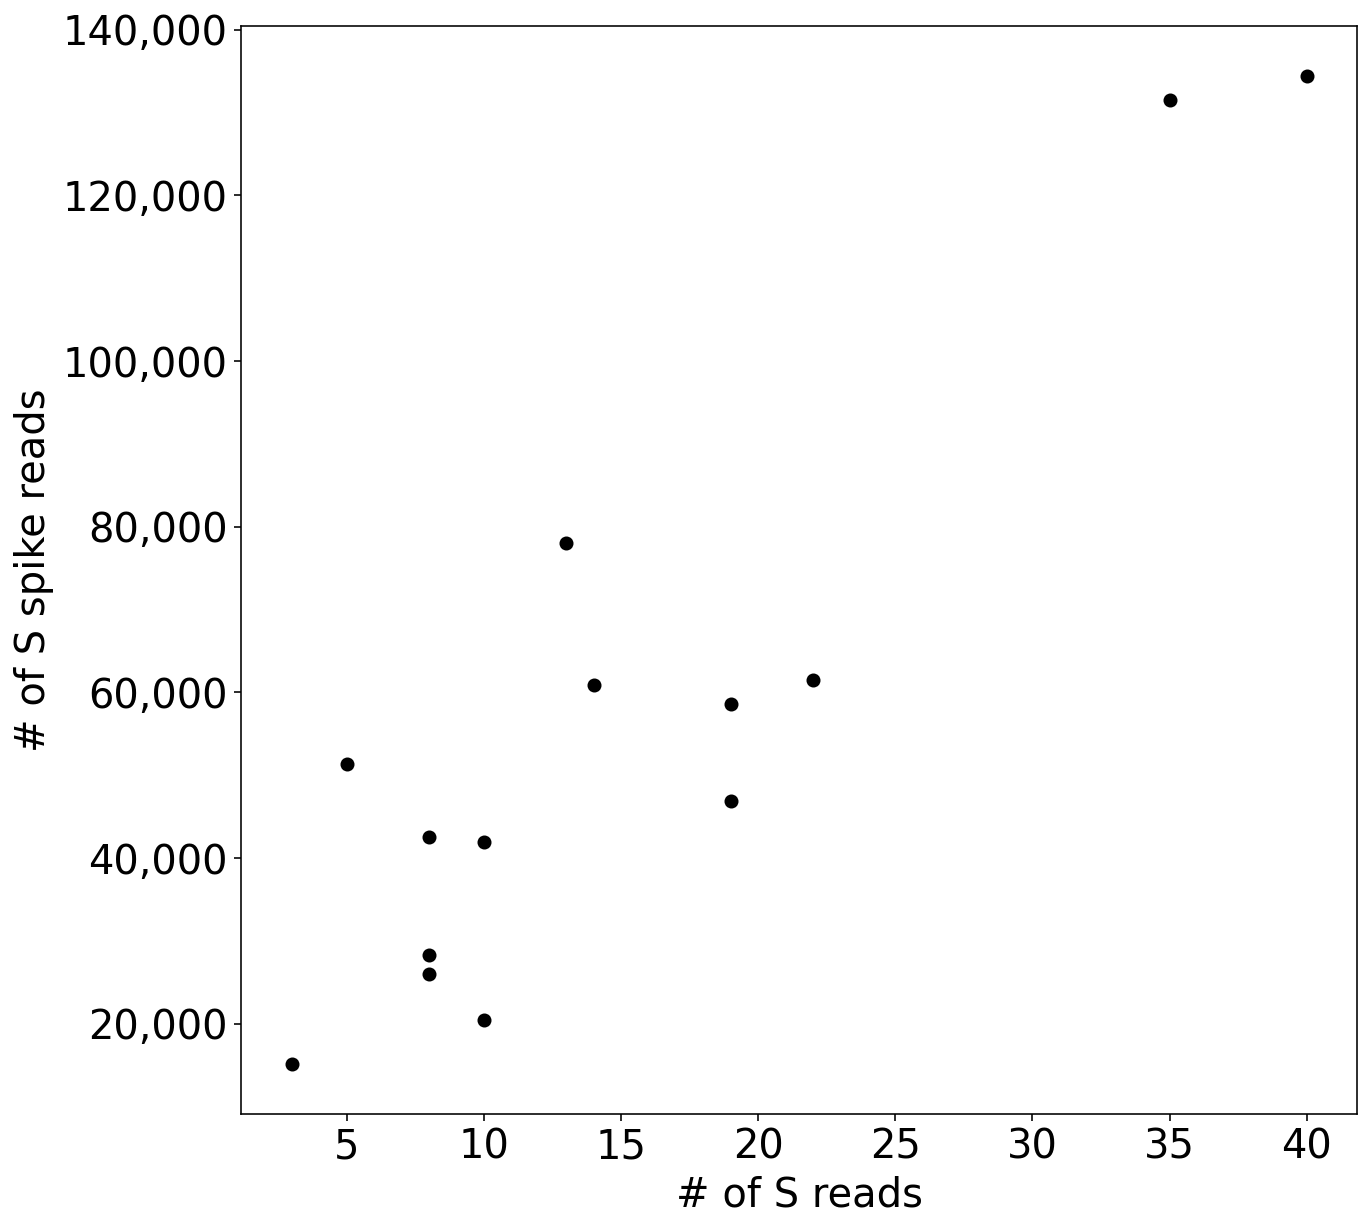

In [39]:
fix, ax = plt.subplots(figsize=(10,10))

x = s
y = s_spike

ax.scatter(x, y, color="k")

kwd = {
    "xlabel": "# of S reads",
    "ylabel": "# of S spike reads"
}

ax.set(**kwd)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

fig.show()

In [40]:
x = ndata.X[ndata.obs.eval("virus_copy == 'Negative Patient' and Plate_ID == 'Plate14'").values].astype(int)[:,0]
y = ndata.X[ndata.obs.eval("virus_copy == 'Negative Patient' and Plate_ID == 'Plate14'").values].astype(int)[:,1]

In [41]:
ndata.X[ndata.obs.eval("virus_copy == 'Negative Patient' and Plate_ID == 'Plate14' and virus_identity != 'TE'").values].astype(int)

array([[     9,  36615,      0,      0,      3],
       [    31, 101787,      0,      0,  16752],
       [    14,  60545,      0,      0,  13314],
       [    23, 108973,      0,      0,  14812],
       [    20, 126273,      0,      0,  14587],
       [    11,  38630,      0,      0,   8113],
       [     1,   7591,      0,      0,  13798],
       [    10,  60833,      0,      0,  14013],
       [    14,  57529,      0,      0,   9063],
       [    25,  73226,      0,      0,  11614],
       [    23,  89342,      0,      0,  19043],
       [    17,  60032,      0,      0,  15027],
       [    12,  70426,      0,      0,   5095],
       [     0,   3574,      0,      0,   8689],
       [    17,  69406,      0,      0,   7512],
       [    12,  36642,      0,      0,   7798],
       [     0,   4793,      0,      0,   2200],
       [    12,  53424,      0,      0,   5313],
       [     6,  13793,      0,      0,   6145],
       [    11,  66084,      0,      0,   8219],
       [     5,  297

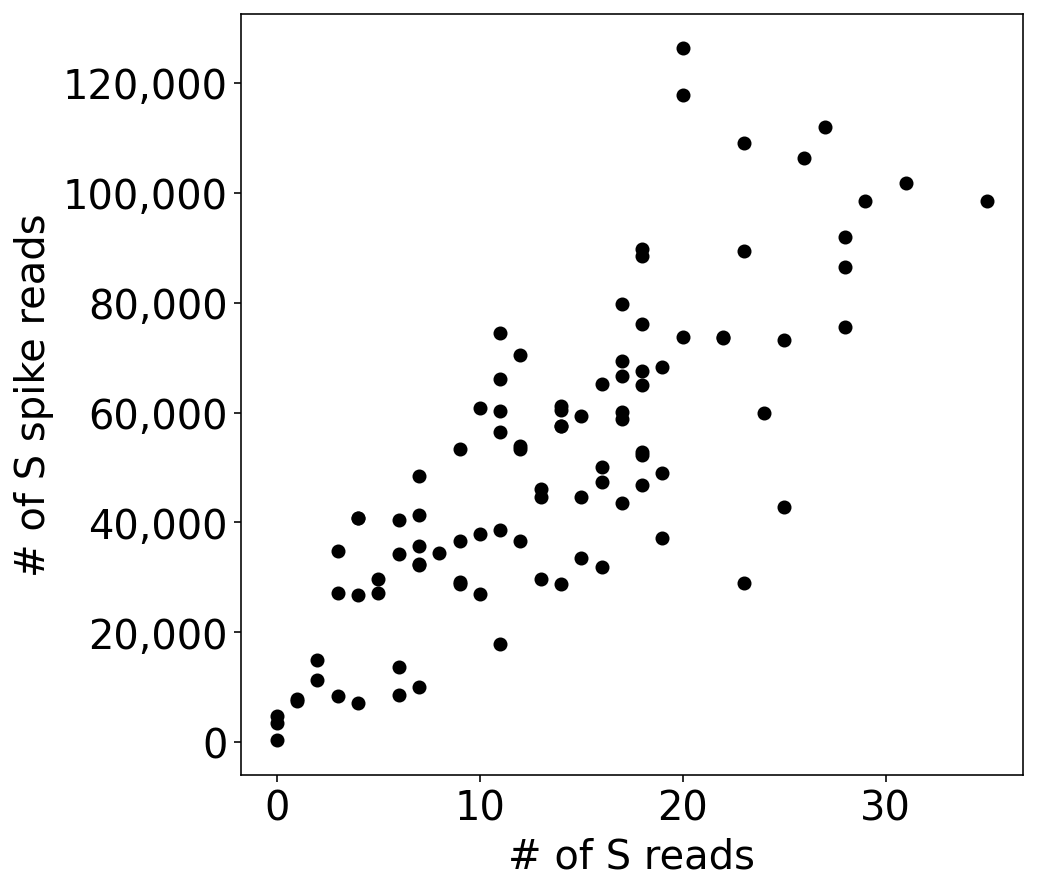

In [42]:
fig, ax = plt.subplots(figsize=(7,7))

x = nd(ndata.X[ndata.obs.eval("virus_copy == 'Negative Patient' and Plate_ID == 'Plate14'").values].astype(int)[:,0])
y = nd(ndata.X[ndata.obs.eval("virus_copy == 'Negative Patient' and Plate_ID == 'Plate14'").values].astype(int)[:,1])


ax.scatter(x, y, color="k")

kwd = {
    "xlabel": "# of S reads",
    "ylabel": "# of S spike reads"
}

ax.set(**kwd)

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

fig.show()

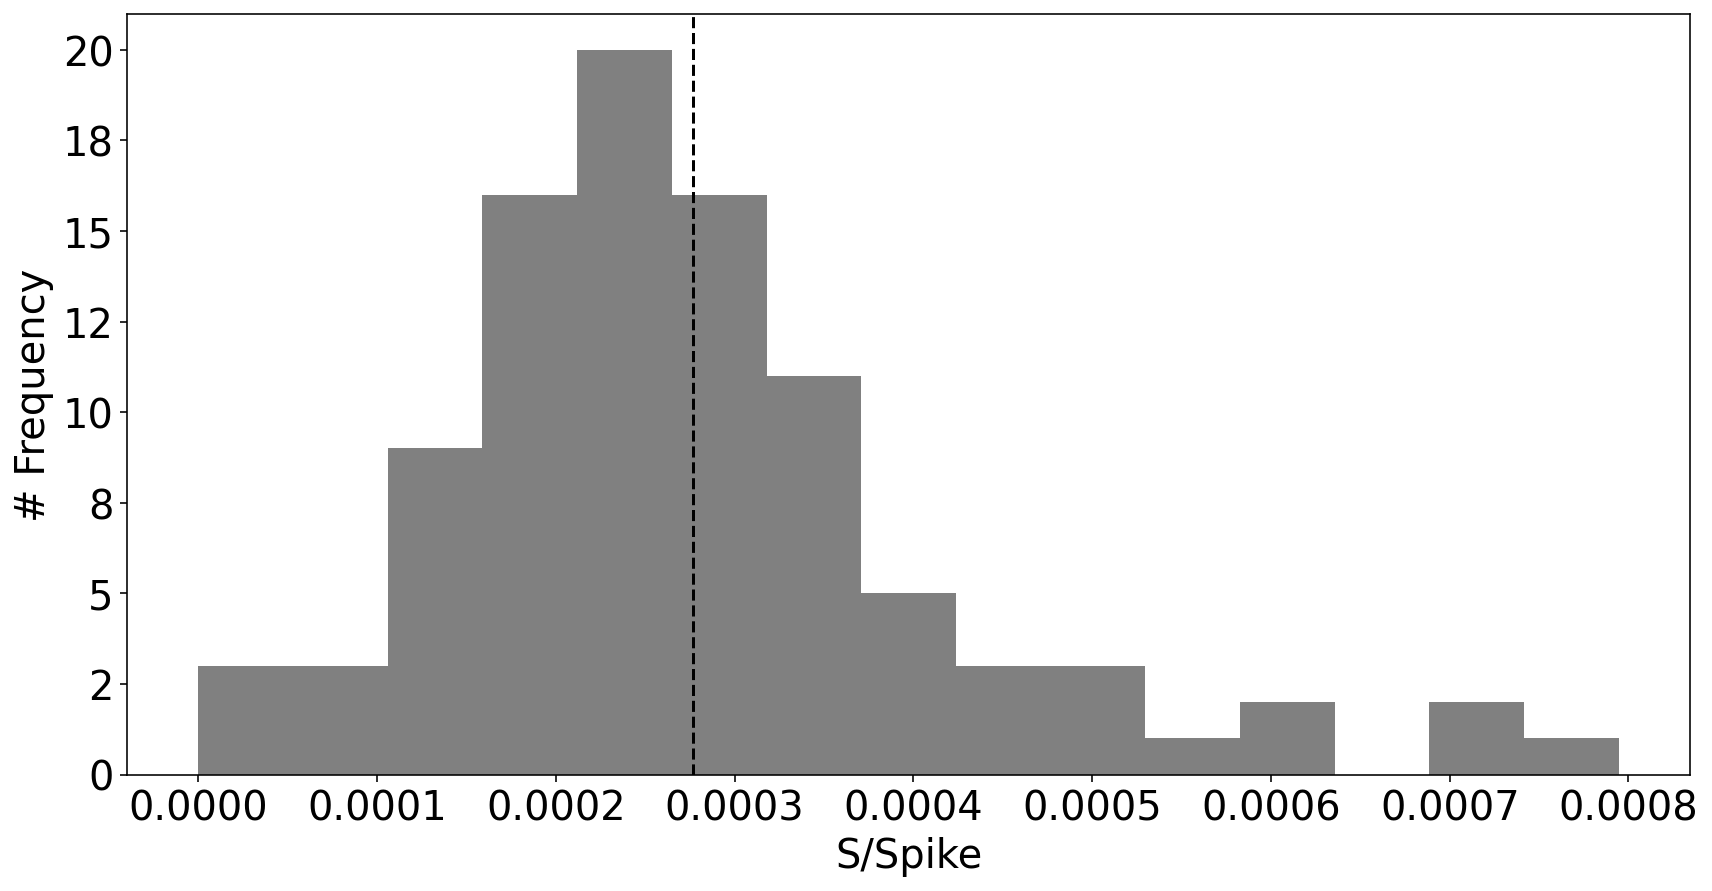

In [43]:
fig, ax = plt.subplots(figsize=(14, 7))

x = nd(ndata.X[ndata.obs.eval("virus_copy == 'Negative Patient' and Plate_ID == 'Plate14'").values].astype(int)[:,0])
y = nd(ndata.X[ndata.obs.eval("virus_copy == 'Negative Patient' and Plate_ID == 'Plate14'").values].astype(int)[:,1])

d = x/y.astype(float)

mean = d.mean()

ax.axvline(x=mean, color="k", linestyle="--")
ax.hist(d, bins=15, color="grey")



kwd = {
    "ylabel": "# Frequency",
    "xlabel": "S/Spike"
}

ax.set(**kwd)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


fig.show()

In [44]:
m = nd(ndata.X[ndata.obs.eval('virus_copy=="0"').values][:,np.logical_or(ndata.var.index.values=='N1', ndata.var.index.values=='S2')].sum(axis=1))>0
worst_idx = np.argmax(ndata[ndata.obs.eval('virus_copy=="0"')][m].X.astype(int)[:,0])
ndata[ndata.obs.eval('virus_copy=="0"')][m].obs.iloc[worst_idx]

Plate_ID                           Plate11
virus_identity                          TE
lysate                    NP swab into VTM
virus_copy                               0
bc_set                         N1_S2_RPP30
Plate_384                                1
Plate_384_quadrant                       3
MasterMixVol                          20uL
RT                                 taqpath
SpikeCopies                            500
RPP_strategy                            50
Sample_Well                            G01
Sample_ID                    Plate11-G01-1
index                           GCCGCAATTC
index2                          AACCATGCAA
bcs                   GCCGCAATTCAACCATGCAA
Name: GCCGCAATTCAACCATGCAA, dtype: object

In [45]:
bcs = ndata[ndata.obs.eval('virus_copy=="0"')][m].obs.iloc[worst_idx].bcs

In [46]:
ndata[ndata.obs.eval(f'bcs=="{bcs}"')].X.astype(int)

ArrayView([[    40, 134426,      0,      0,     16]])

In [47]:
nd(ndata[ndata.obs.eval(f'bcs=="{bcs}"')].X.astype(int))[0]/nd(ndata[ndata.obs.eval(f'bcs=="{bcs}"')].X.astype(int))[1]

0.0002975614836415574

In [48]:
mean

0.00027673257275524164

In [49]:
np.sqrt(d.var())

0.00014291010287520887

In [50]:
d.mean()

0.00027673257275524164

# Paper figure

In [51]:
# plotting functions
def fmt(s, pos):
  x = int(s)
  return f"{x:,.0f}"
  
def cbar(sc, loc):
  divider = make_axes_locatable(loc)
  cax = divider.append_axes('right', size='5%', pad=0.05)

  fig.colorbar(sc, cax=cax, orientation='vertical', format=mpl.ticker.FuncFormatter(fmt), label="log1p(Counts)")
  return

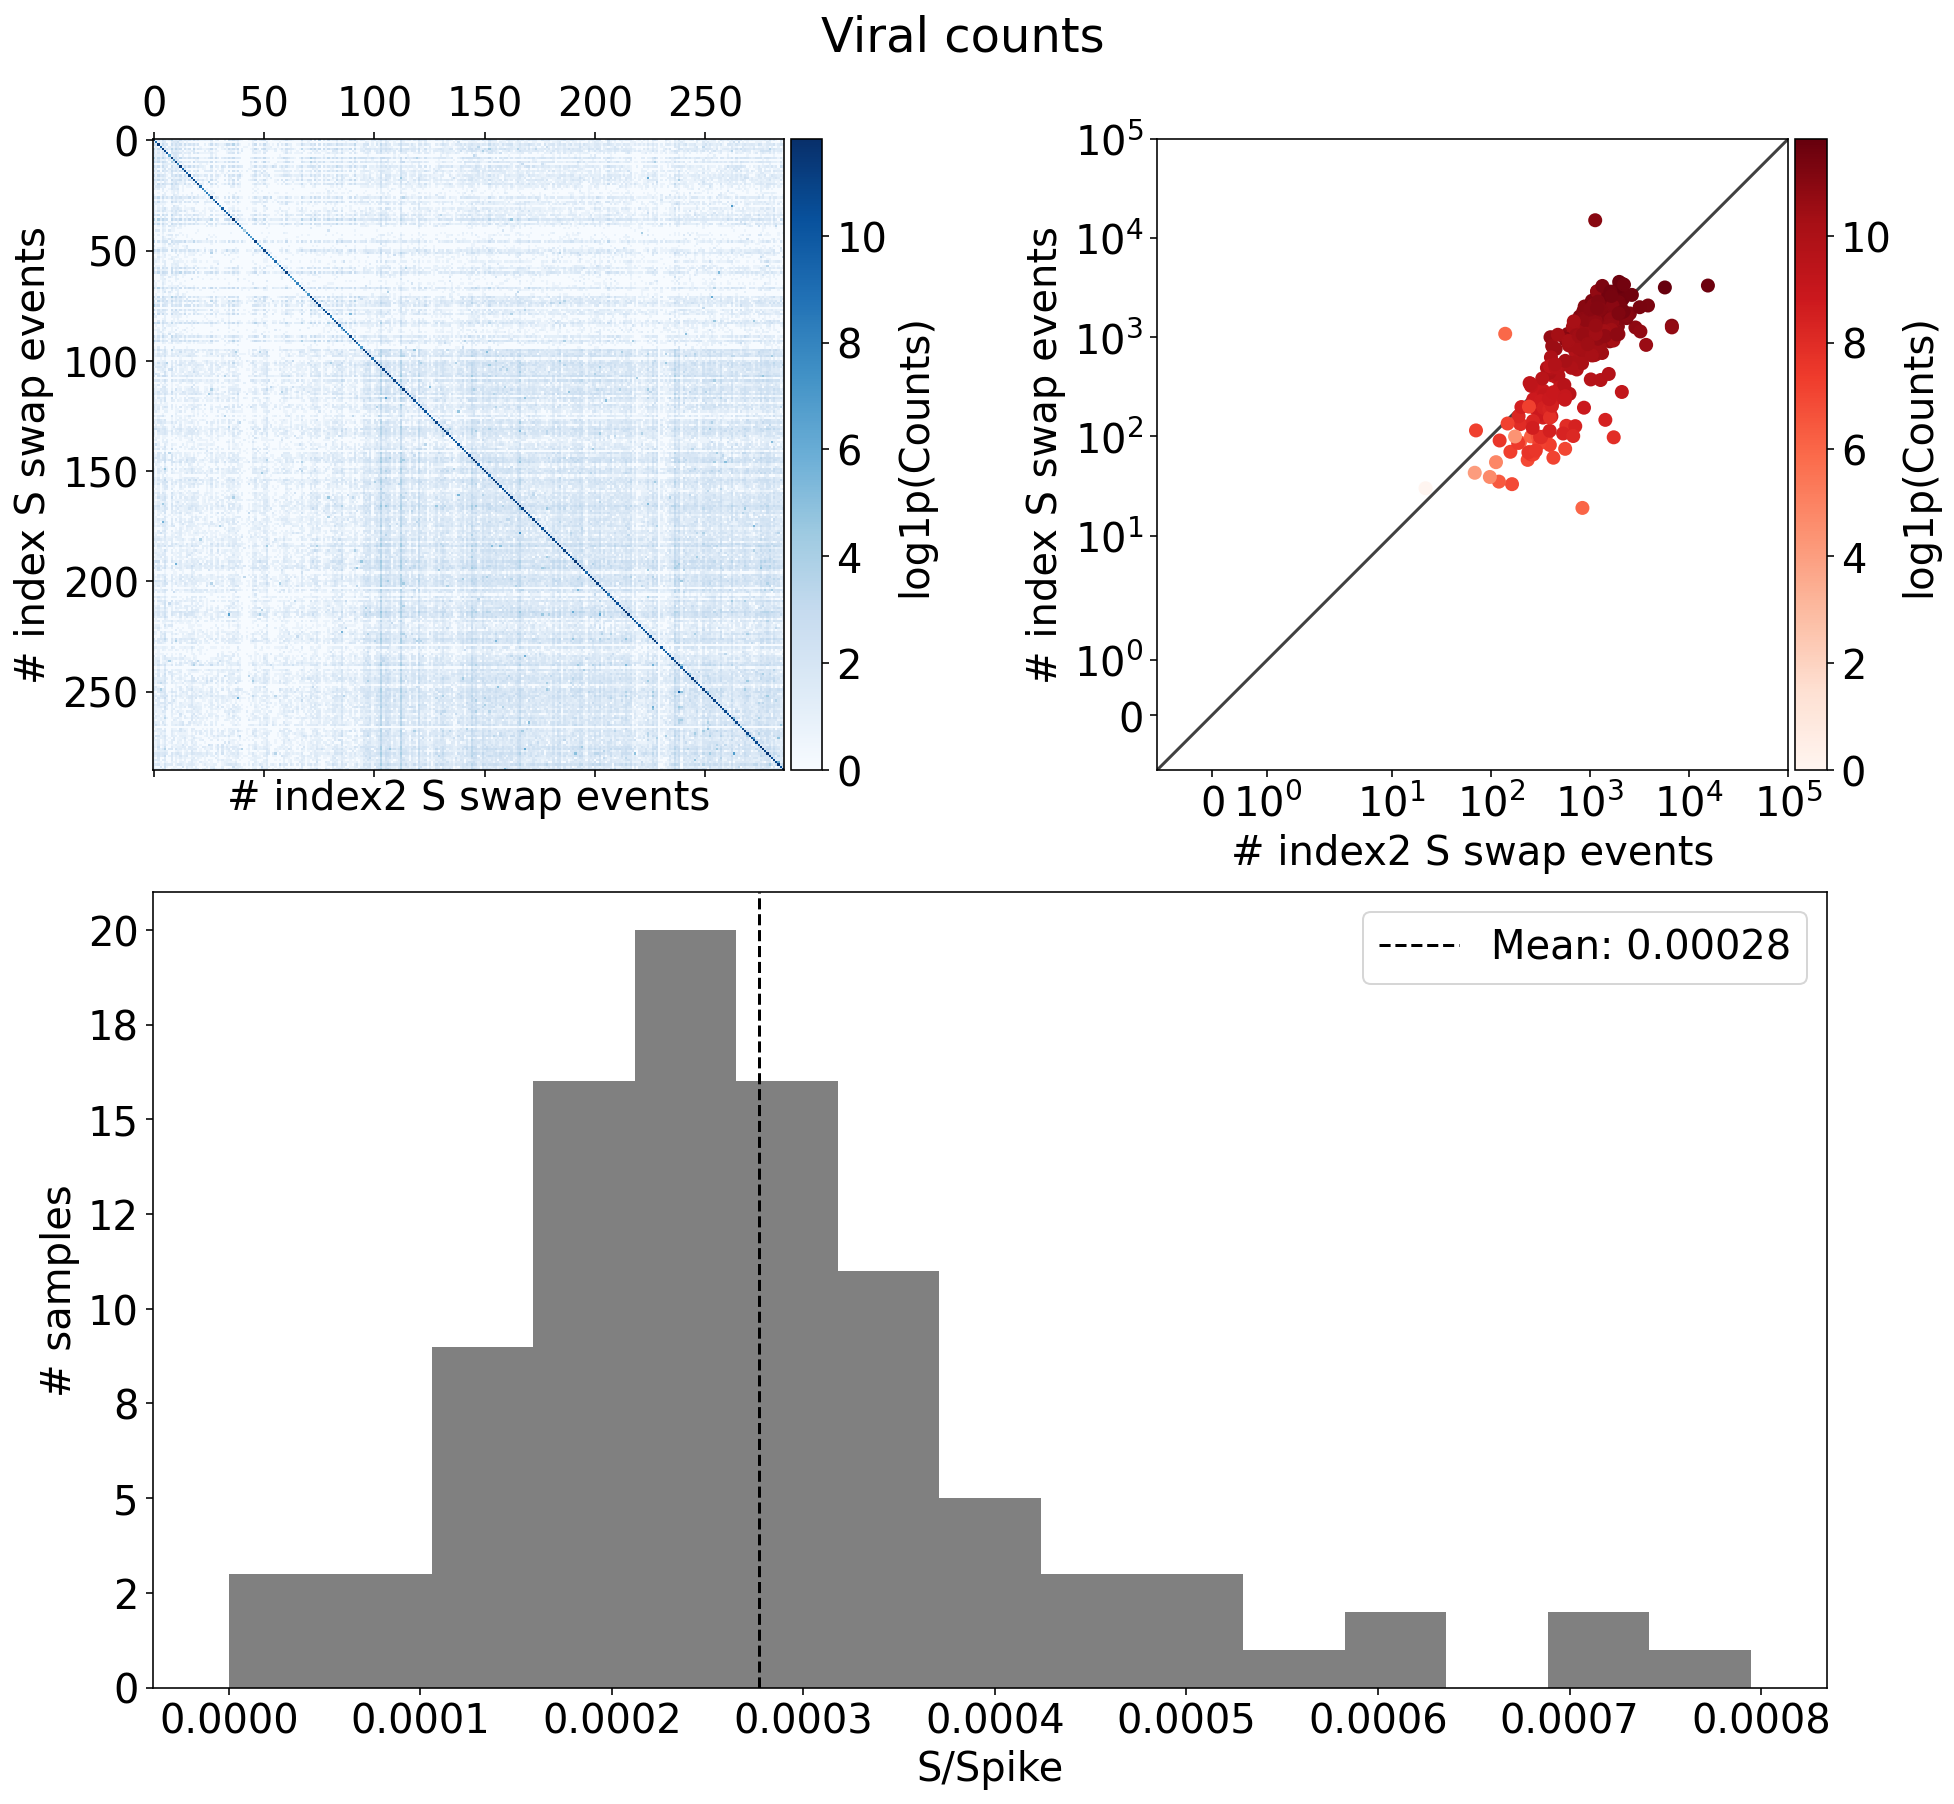

In [52]:
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.05, wspace=0.5)

fig.suptitle("Viral counts", y=0.9)

gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
###
# Data

diag = np.diag(conf[0])[dir_mask]

off_0 = conf[0].sum(axis=0)[dir_mask] - diag
off_1 = conf[0].sum(axis=1)[dir_mask] - diag

mat = np.log1p(conf[0][dir_mask,:][:,dir_mask])

###
loc = fig.add_subplot(gs[0, 0])

submat = mat[~isr_mask,:][:,~isr_mask]

im = loc.matshow(submat, cmap='Blues')
kwd = {
    "xlabel": "# index2 S swap events",
    "ylabel": "# index S swap events"
    }

loc.set(**kwd)
cbar(im, loc)

###
loc = fig.add_subplot(gs[0, 1])
kwd = {
    "xscale": "symlog",
    "yscale": "symlog",
    "xlim": (-1, 1e5),
    "ylim": (-1, 1e5),
    "xlabel": "# index2 S swap events",
    "ylabel": "# index S swap events"
}

well_total = np.log1p(diag[~isr_mask])

x = off_0[~isr_mask]
y = off_1[~isr_mask]

sc = loc.scatter(x, y, c=well_total, cmap="Reds")

kwd.update({
    "xlabel": "# index2 S swap events",
    "ylabel": "# index S swap events"
    })
loc.set(**kwd)

yex(loc)
cbar(sc, loc)

###
loc = fig.add_subplot(gs[1,:])

x = nd(ndata.X[ndata.obs.eval("virus_copy == 'Negative Patient' and Plate_ID == 'Plate14'").values].astype(int)[:,0])
y = nd(ndata.X[ndata.obs.eval("virus_copy == 'Negative Patient' and Plate_ID == 'Plate14'").values].astype(int)[:,1])

d = x/y.astype(float)

mean = d.mean()

loc.axvline(x=mean, color="k", linestyle="--", label=f"Mean: {mean:,.5f}")
loc.hist(d, bins=15, color="grey")



kwd = {
    "ylabel": "# samples",
    "xlabel": "S/Spike"
}

loc.set(**kwd)
loc.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

loc.legend()
fig.savefig("./barcode_swapping.png",bbox_inches='tight', dpi=300)
fig.show()

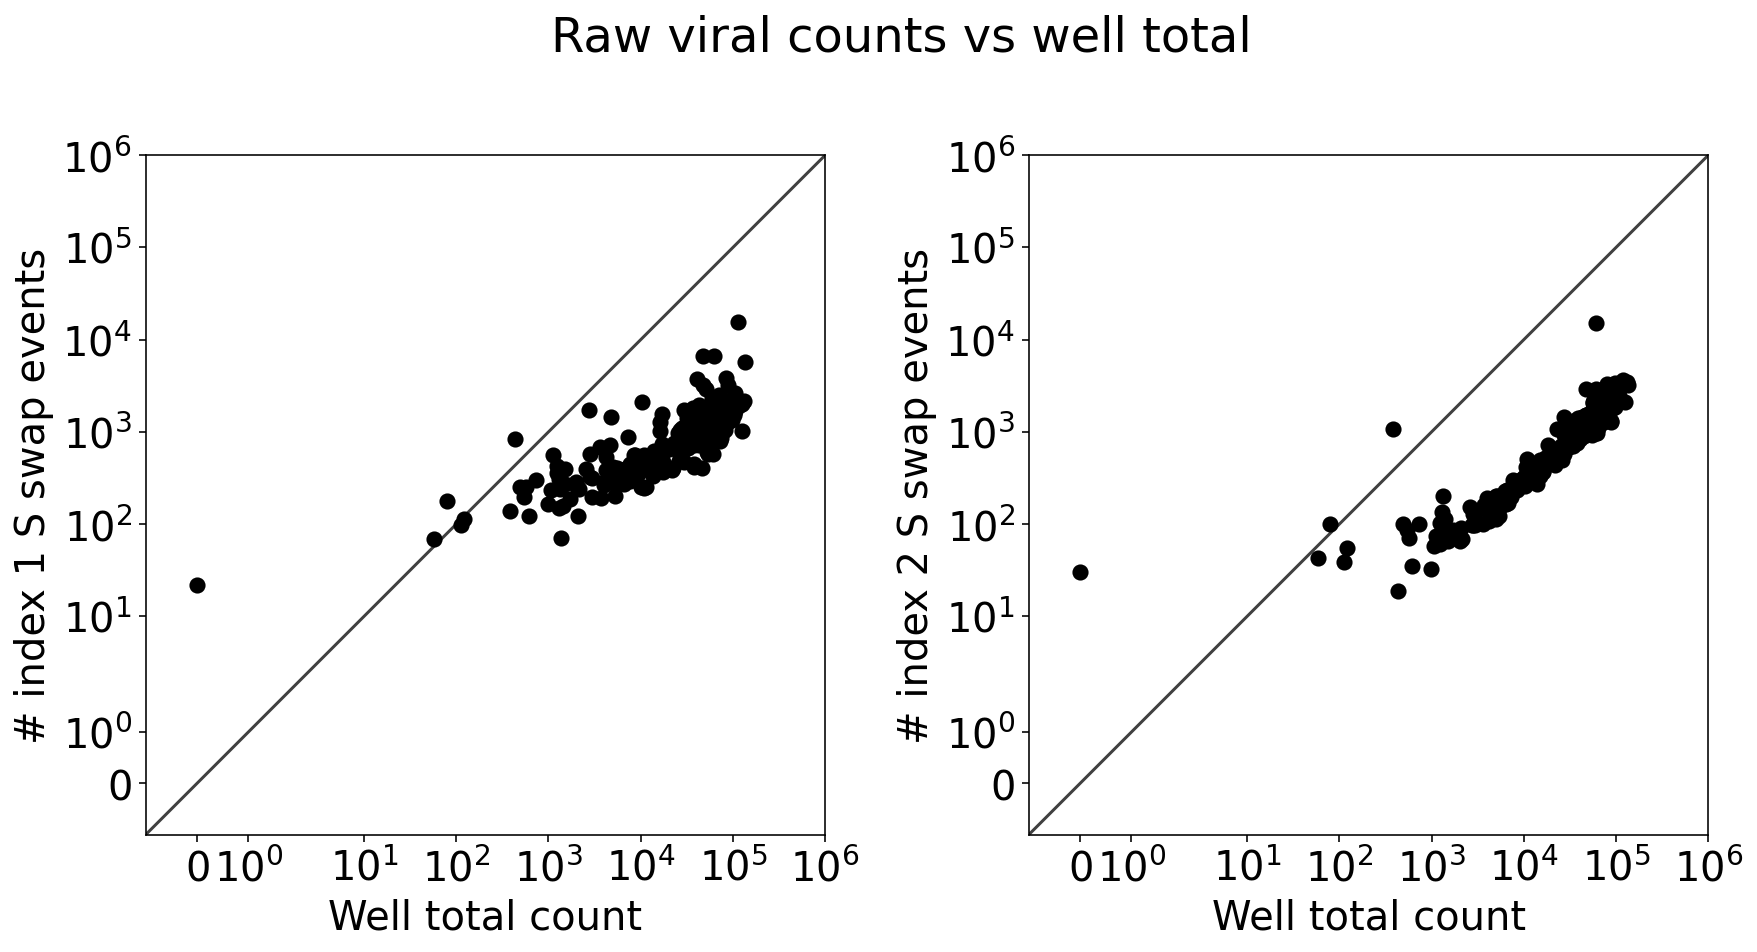

In [74]:
#@title Raw Viral Counts

def fmt(s, pos):
  x = int(s)
  return f"{x:,.0f}"
def cbar(sc, loc):
  divider = make_axes_locatable(loc)
  cax = divider.append_axes('right', size='5%', pad=0.05)

  fig.colorbar(sc, cax=cax, orientation='vertical', format=mpl.ticker.FuncFormatter(fmt))
  return

diag = np.diag(conf[0])[dir_mask]

off_0 = conf[0].sum(axis=0)[dir_mask] - diag
off_1 = conf[0].sum(axis=1)[dir_mask] - diag


#######
fig, ax = plt.subplots(figsize=(14,7), ncols=2)
fig.subplots_adjust(hspace=0.05, wspace=0.3)

fig.suptitle("Raw viral counts vs well total")

kwd = {
    "xscale": "symlog",
    "yscale": "symlog",
    "xlim": (-1, 1e6),
    "ylim": (-1, 1e6),
}

loc = ax[0]

well_total = diag[~isr_mask]

x = off_0[~isr_mask]
y = off_1[~isr_mask]

sc = loc.scatter(well_total, x, s=50, color="k")

kwd.update({
    "xlabel": "Well total count",
    "ylabel": "# index 1 S swap events"
    })
loc.set(**kwd)

yex(loc)

###
loc = ax[1]

well_total = diag[~isr_mask]

x = off_0[~isr_mask]
y = off_1[~isr_mask]

sc = loc.scatter(well_total, y, s=50, color="k")

kwd.update({
    "xlabel": "Well total count",
    "ylabel": "# index 2 S swap events"
    })
loc.set(**kwd)

yex(loc)
fig.savefig("./barcode_swap_vs_well_total.png",bbox_inches='tight', dpi=300)
fig.show()

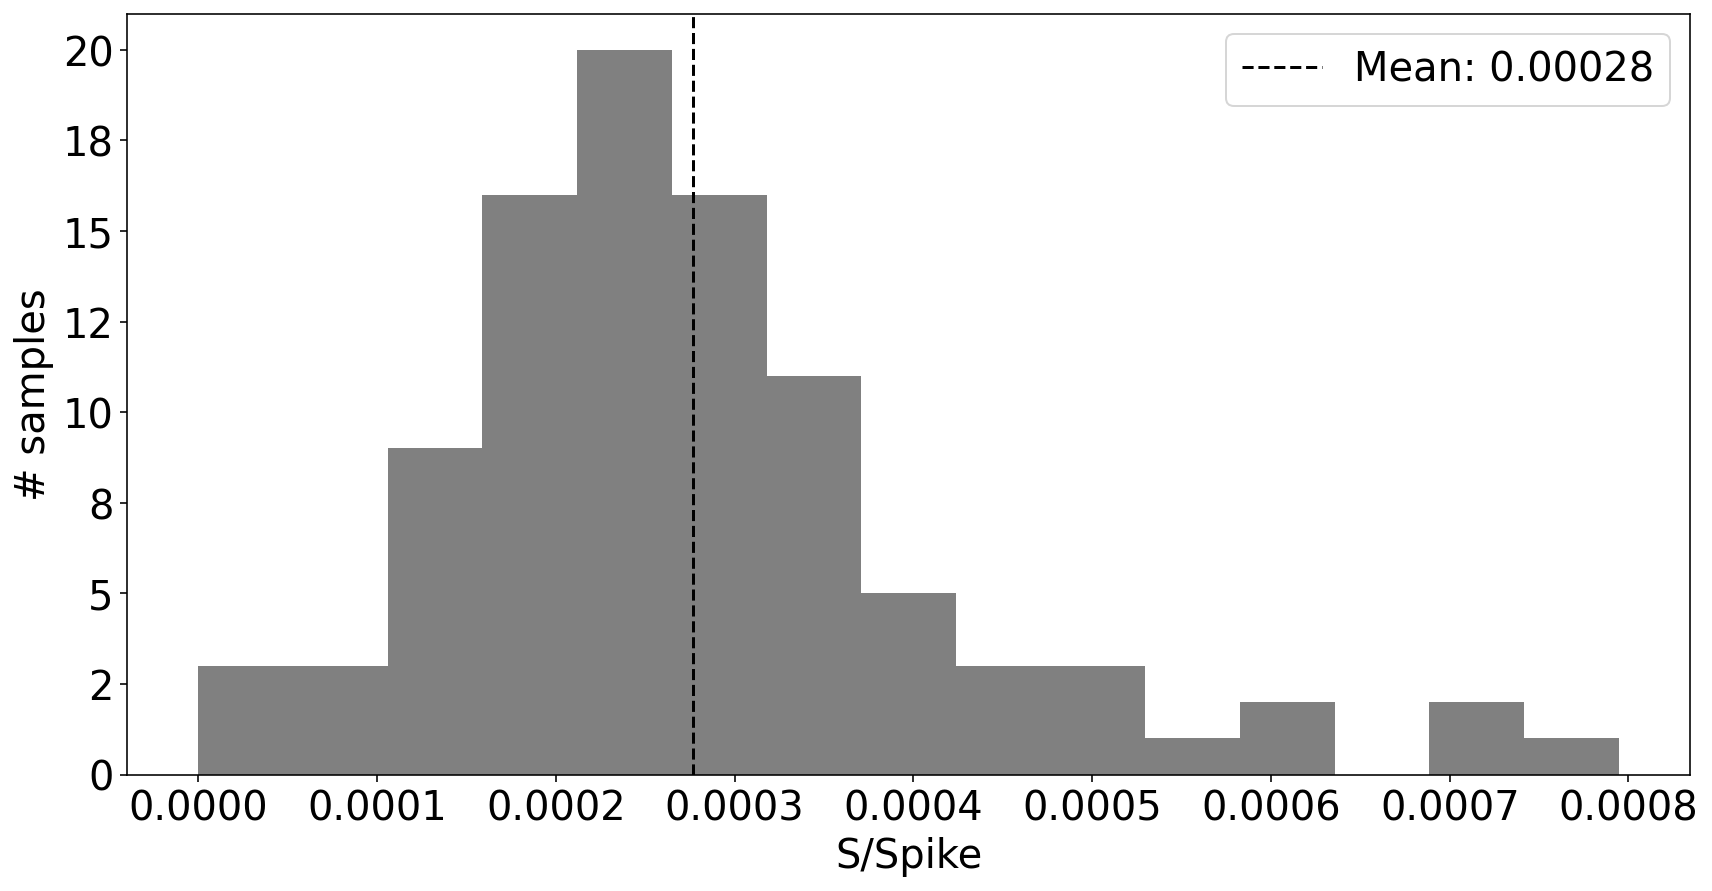

In [75]:
fig, ax = plt.subplots(figsize=(14,7))

loc = ax

x = nd(ndata.X[ndata.obs.eval("virus_copy == 'Negative Patient' and Plate_ID == 'Plate14'").values].astype(int)[:,0])
y = nd(ndata.X[ndata.obs.eval("virus_copy == 'Negative Patient' and Plate_ID == 'Plate14'").values].astype(int)[:,1])

d = x/y.astype(float)

mean = d.mean()

loc.axvline(x=mean, color="k", linestyle="--", label=f"Mean: {mean:,.5f}")
loc.hist(d, bins=15, color="grey")

kwd = {
    "ylabel": "# samples",
    "xlabel": "S/Spike"
}

loc.set(**kwd)
loc.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

loc.legend()
fig.savefig("./ratio_distribution.png",bbox_inches='tight', dpi=300)
fig.show()